In [4]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import csv
from scipy.interpolate import interp1d
import json
import copy

%matplotlib inline

# Information from Paper

* flowrate of 150 mL/min
* PFOA (402 ppm), air, & H2O (750 ppm)
* temperature profiles from SI are used 


Load in temperature profiles from paper

TEMP  ACTUAL TEMP IN CENTER  Difference
800 	 712.6824333155304 	 87.31756668446963
850 	 770.015506327582 	 79.98449367241801
900 	 823.3927715664618 	 76.60722843353824
950 	 874.795037329749 	 75.204962670251
1000 	 940.0339170661575 	 59.96608293384247
1050 	 1001.3189253033898 	 48.68107469661015
1100 	 1025.0421542984475 	 74.95784570155251
Customizing profiles for 400-750 with average peak temperature difference of 71.81703639895457 deg C.



Calculated maximum value for 400: 328.72, should be close to 328.18296360104546
Calculated maximum value for 450: 378.18, should be close to 378.18296360104546
Calculated maximum value for 500: 428.18, should be close to 428.18296360104546
Calculated maximum value for 550: 478.18, should be close to 478.18296360104546
Calculated maximum value for 600: 528.18, should be close to 528.1829636010455
Calculated maximum value for 650: 578.19, should be close to 578.1829636010455
Calculated maximum value for 700: 628.18, should be close to 628.182

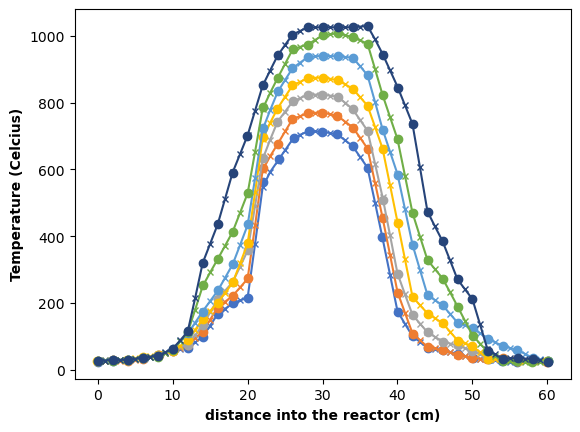

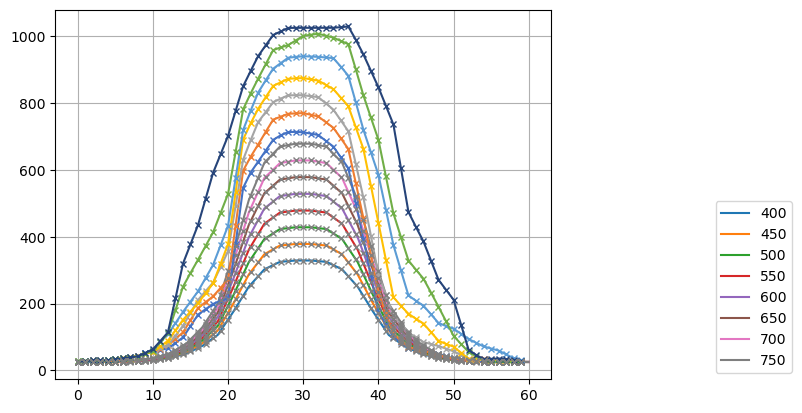

In [5]:
temperature_profiles = pd.read_csv('temperature_profiles_from_literature.csv')

temperatures = range(800,1150, 50)
master_temp_dict = {}

#start plotting
fig = plt.figure()
ax1 = fig.add_subplot(111)


rbg_colors = {800: (68, 114, 196), 
              850: (238, 125, 49), 
              900: (165, 165, 165), 
              950: (255, 192, 2), 
              1000: (91, 156, 213), 
              1050: (112, 174, 71), 
              1100: (38, 68, 121)}
    
for temp in temperatures:
    
    index_of_x = temperature_profiles.columns.get_loc(str(temp))
    index_of_y = index_of_x+1 
    
    distances_str = temperature_profiles.iloc[:, index_of_x]
    distances = [float(x) for x in distances_str[1:]]
    
    temperatures_at_distances_str = temperature_profiles.iloc[:, index_of_y]
    temperatures_at_distances = [float(x) for x in temperatures_at_distances_str[1:]]
        
    colors = tuple([color_num/255 for color_num in rbg_colors[temp]])
    
    ax1.plot(distances, temperatures_at_distances,'o',c=colors)
    
    
    #create an interpolation function 
    T_profile = interp1d(distances, temperatures_at_distances, kind='linear', fill_value='extrapolate')
    more_points_distances = range(0, 60, 1)
    ax1.plot(more_points_distances, [T_profile(z) for z in more_points_distances],'x-',c=colors, markersize=5, label=f"corrections to ABL, no branching")

   #append to master dictionary so we can use this is PFR sims
    master_temp_dict[temp] = [distances, temperatures_at_distances, T_profile]
    
plt.xlabel('distance into the reactor (cm)',fontweight='bold')
plt.ylabel('Temperature (Celcius)',fontweight='bold')

# customized temperature profile for 400 - 750 degrees C 
print('TEMP  ACTUAL TEMP IN CENTER  Difference')
temp_differences_at_peak = []

for temp in temperatures:
    
    index_of_x = temperature_profiles.columns.get_loc(str(temp))
    index_of_y = index_of_x+1 
    
    distances_str = temperature_profiles.iloc[:, index_of_x]
    distances = [float(x) for x in distances_str[1:]]
    
    temperatures_at_distances_str = temperature_profiles.iloc[:, index_of_y]
    temperatures_at_distances = [float(x) for x in temperatures_at_distances_str[1:]]
        
    
    #find the index of the distances that is closes to 30 
    difference_from_30 = [abs(30-x) for x in distances]
    closest_to_30 = min(difference_from_30)
    index_for_center_of_reactor = difference_from_30.index(closest_to_30)

    print(temp, '\t', temperatures_at_distances[index_for_center_of_reactor], '\t', temp-temperatures_at_distances[index_for_center_of_reactor])
    temp_differences_at_peak.append(temp-temperatures_at_distances[index_for_center_of_reactor])

average_difference = np.average(temp_differences_at_peak)
print(f'Customizing profiles for 400-750 with average peak temperature difference of {average_difference} deg C.\n\n\n')

def custom_gaussian(x, min_val, max_val, mean, std_dev):
    """
    Generates a Gaussian function with specified minimum and maximum values.

    Args:
        x (numpy.ndarray or float): The input value(s).
        min_val (float): The minimum value (offset) of the function.
        max_val (float): The desired maximum value of the function.
        mean (float): The mean (center) of the Gaussian peak.
        std_dev (float): The standard deviation (width) of the Gaussian.

    Returns:
        numpy.ndarray or float: The calculated Gaussian value(s).
    """
    amplitude = max_val - min_val
    # The standard Gaussian formula
    y = amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2)) + min_val
    return y

#start plotting the whole thing
fig = plt.figure()
ax1 = fig.add_subplot(111)


manual_adjustments = {400: 89,
450: 478.37 - 378.18296360104546,
500: 539.01 - 428.18296360104546,
550: 599.66 - 478.18296360104546,
600: 660.30 - 528.1829636010455,
650: 720.94 - 578.1829636010455,
700: 781.59 - 628.1829636010455,
750: 842.23 - 678.1829636010455,
                     }
                      
temperatures_to_customize = range(400,800,50)
for cust_temp in temperatures_to_customize: 
    
    ##### get custom temperature profile edges (distances 0-25, 35-60)
 
    # Parameters
    min_val = 25 #deg C
    max_val = cust_temp - average_difference #always a little lower than desired temperature
    mean = 30 #cm
    std_dev = 7

    # Generate x values
    x_values = np.linspace(0, 60, 30) # Range from -4*sigma to 4*sigma covers most of the curve

    # Calculate the corresponding y values
    y_values_edges = custom_gaussian(x_values, min_val, max_val, mean, std_dev)
    T_profile_edges = interp1d(x_values, y_values_edges, kind='linear', fill_value='extrapolate')

    
    ##### get custom temperature profile for middle (distances 25-35)
    # Parameters
    mean_1, mean_2 = 25, 35 #cm
    std_dev = 5


    # Calculate the corresponding y values
    y_values_1 = custom_gaussian(x_values, min_val, max_val, mean_1, std_dev)
    y_values_2 = custom_gaussian(x_values, min_val, max_val, mean_2, std_dev)
    
    T_profile_1 = interp1d(x_values, y_values_1, kind='linear', fill_value='extrapolate')
    T_profile_2 = interp1d(x_values, y_values_2, kind='linear', fill_value='extrapolate')



    ######### put the y values together and run through the interpolate function to get final temperature profile 
    desired_y_values = []
    for x in x_values: 
        if x<20: 
            y = T_profile_edges(x)
        if x>=20 and x<=40: 
            y = T_profile_1(x) + T_profile_2(x) - manual_adjustments[cust_temp] #drop middle section down so it connects to edges
        if x>40: 
            y = T_profile_edges(x)
        desired_y_values.append(y)
        
    final_T_profile = interp1d(x_values, desired_y_values, kind='linear', fill_value='extrapolate')

    
    
    ax1.plot(x_values, [final_T_profile(x) for x in x_values], label=f'{cust_temp}')

    
    
    
    # Verify the min and max values (should be close to the defined parameters)
    print(f"Calculated maximum value for {cust_temp}: {np.max([final_T_profile(x) for x in x_values]):.2f}, should be close to {max_val}")

    
    #overwrite with new custom temp profiles 
    master_temp_dict[cust_temp] = [x_values, [final_T_profile(x) for x in x_values], final_T_profile]
    
    
rbg_colors = {800: (68, 114, 196), 
              850: (238, 125, 49), 
              900: (165, 165, 165), 
              950: (255, 192, 2), 
              1000: (91, 156, 213), 
              1050: (112, 174, 71), 
              1100: (38, 68, 121)}
    
for temp, [distances, temperatures_at_distances, T_profile] in master_temp_dict.items():

    #create an interpolation function 
    more_points_distances = range(0, 60, 1)
    
    #800 - 1100 K
    if temp in rbg_colors.keys():
        colors = tuple([color_num/255 for color_num in rbg_colors[temp]])
        ax1.plot(more_points_distances, [T_profile(z) for z in more_points_distances],'x-',c=colors, markersize=5,)
        
    else: 
        ax1.plot(more_points_distances, [T_profile(z) for z in more_points_distances],'x', c='gray', markersize=5,)


plt.grid(True)
plt.legend(bbox_to_anchor=(1.5,0.5))

TEMP  ACTUAL TEMP IN CENTER  Difference
800 	 712.6824333155304 	 87.31756668446963
850 	 770.015506327582 	 79.98449367241801
900 	 823.3927715664618 	 76.60722843353824
950 	 874.795037329749 	 75.204962670251
1000 	 940.0339170661575 	 59.96608293384247
1050 	 1001.3189253033898 	 48.68107469661015
1100 	 1025.0421542984475 	 74.95784570155251
Customizing profiles for 400-750 with average peak temperature difference of 71.81703639895457 deg C.



Calculated maximum value for 400: 400.00, should be close to 400
Calculated maximum value for 450: 450.00, should be close to 450
Calculated maximum value for 500: 500.00, should be close to 500
Calculated maximum value for 550: 550.00, should be close to 550
Calculated maximum value for 600: 600.00, should be close to 600
Calculated maximum value for 650: 650.00, should be close to 650
Calculated maximum value for 700: 700.00, should be close to 700
Calculated maximum value for 750: 750.00, should be close to 750
Calculated maximum value f

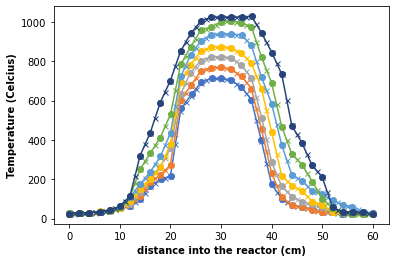

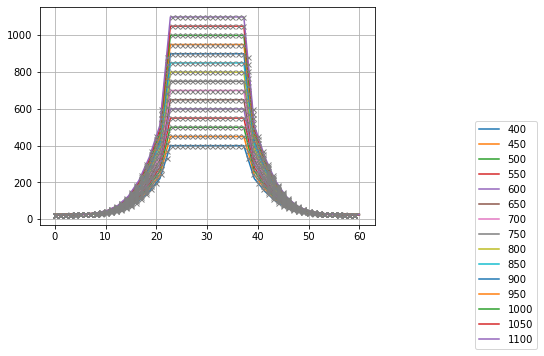

In [3]:
temperature_profiles = pd.read_csv('temperature_profiles_from_literature.csv')

temperatures = range(800,1150, 50)
master_temp_dict = {}

#start plotting
fig = plt.figure()
ax1 = fig.add_subplot(111)


rbg_colors = {800: (68, 114, 196), 
              850: (238, 125, 49), 
              900: (165, 165, 165), 
              950: (255, 192, 2), 
              1000: (91, 156, 213), 
              1050: (112, 174, 71), 
              1100: (38, 68, 121)}
    
for temp in temperatures:
    
    index_of_x = temperature_profiles.columns.get_loc(str(temp))
    index_of_y = index_of_x+1 
    
    distances_str = temperature_profiles.iloc[:, index_of_x]
    distances = [float(x) for x in distances_str[1:]]
    
    temperatures_at_distances_str = temperature_profiles.iloc[:, index_of_y]
    temperatures_at_distances = [float(x) for x in temperatures_at_distances_str[1:]]
        
    colors = tuple([color_num/255 for color_num in rbg_colors[temp]])
    
    ax1.plot(distances, temperatures_at_distances,'o',c=colors)
    
    
    #create an interpolation function 
    T_profile = interp1d(distances, temperatures_at_distances, kind='linear', fill_value='extrapolate')
    more_points_distances = range(0, 60, 1)
    ax1.plot(more_points_distances, [T_profile(z) for z in more_points_distances],'x-',c=colors, markersize=5, label=f"corrections to ABL, no branching")

   #append to master dictionary so we can use this is PFR sims
    master_temp_dict[temp] = [distances, temperatures_at_distances, T_profile]
    
plt.xlabel('distance into the reactor (cm)',fontweight='bold')
plt.ylabel('Temperature (Celcius)',fontweight='bold')

# customized temperature profile for 400 - 750 degrees C 
print('TEMP  ACTUAL TEMP IN CENTER  Difference')
temp_differences_at_peak = []

for temp in temperatures:
    
    index_of_x = temperature_profiles.columns.get_loc(str(temp))
    index_of_y = index_of_x+1 
    
    distances_str = temperature_profiles.iloc[:, index_of_x]
    distances = [float(x) for x in distances_str[1:]]
    
    temperatures_at_distances_str = temperature_profiles.iloc[:, index_of_y]
    temperatures_at_distances = [float(x) for x in temperatures_at_distances_str[1:]]
        
    
    #find the index of the distances that is closes to 30 
    difference_from_30 = [abs(30-x) for x in distances]
    closest_to_30 = min(difference_from_30)
    index_for_center_of_reactor = difference_from_30.index(closest_to_30)

    print(temp, '\t', temperatures_at_distances[index_for_center_of_reactor], '\t', temp-temperatures_at_distances[index_for_center_of_reactor])
    temp_differences_at_peak.append(temp-temperatures_at_distances[index_for_center_of_reactor])

average_difference = np.average(temp_differences_at_peak)
print(f'Customizing profiles for 400-750 with average peak temperature difference of {average_difference} deg C.\n\n\n')



def custom_gaussian(x, min_val, max_val, mean, std_dev):
    """
    Generates a Gaussian function with specified minimum and maximum values.

    Args:
        x (numpy.ndarray or float): The input value(s).
        min_val (float): The minimum value (offset) of the function.
        max_val (float): The desired maximum value of the function.
        mean (float): The mean (center) of the Gaussian peak.
        std_dev (float): The standard deviation (width) of the Gaussian.

    Returns:
        numpy.ndarray or float: The calculated Gaussian value(s).
    """
    amplitude = max_val - min_val
    # The standard Gaussian formula
    y = amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2)) + min_val
    return y


# using isothermal for entire range


#start plotting the whole thing
fig = plt.figure()
ax1 = fig.add_subplot(111)

isothermal_all_dict = {}
                 
temperatures_to_customize = range(400,1150,50)
for cust_temp in temperatures_to_customize: 
    
    ##### get custom temperature profile edges (distances 0-25, 35-60)
 
    # Parameters
    overshoot = 100
    min_val = 25 #deg C
    max_val = cust_temp + overshoot #overshoot a little higher so the edges match up with the isothermal middle
    mean = 30 #cm
    std_dev = 7

    # Generate x values
    x_values = np.linspace(0, 60, 30) # Range from -4*sigma to 4*sigma covers most of the curve

    # Calculate the corresponding y values
    y_values_edges = custom_gaussian(x_values, min_val, max_val, mean, std_dev)
    T_profile_edges = interp1d(x_values, y_values_edges, kind='linear', fill_value='extrapolate')

    
    ##### get custom temperature profile for middle (distances 25-35)
    # Parameters
    mean_1, mean_2 = 25, 35 #cm
    std_dev = 5


    # Calculate the corresponding y values
    y_values_1 = custom_gaussian(x_values, min_val, max_val, mean_1, std_dev)
    y_values_2 = custom_gaussian(x_values, min_val, max_val, mean_2, std_dev)
    
    T_profile_1 = interp1d(x_values, y_values_1, kind='linear', fill_value='extrapolate')
    T_profile_2 = interp1d(x_values, y_values_2, kind='linear', fill_value='extrapolate')



    ######### put the y values together and run through the interpolate function to get final temperature profile 
    desired_y_values = []
    for x in x_values: 
        if x<22.5: 
            y = T_profile_edges(x)
        if x>=22.5 and x<=37.5: 
            y = cust_temp #isothermal middle
        if x>37.5: 
            y = T_profile_edges(x)
        desired_y_values.append(y)
        
    final_T_profile = interp1d(x_values, desired_y_values, kind='linear', fill_value='extrapolate')

    
    
    ax1.plot(x_values, [final_T_profile(x) for x in x_values], label=f'{cust_temp}')

    
    
    
    # Verify the min and max values (should be close to the defined parameters)
    print(f"Calculated maximum value for {cust_temp}: {np.max([final_T_profile(x) for x in x_values]):.2f}, should be close to {cust_temp}")

    
    #add to master dictionary
    isothermal_all_dict[cust_temp] = [x_values, [final_T_profile(x) for x in x_values], final_T_profile]
    
    
rbg_colors = {800: (68, 114, 196), 
              850: (238, 125, 49), 
              900: (165, 165, 165), 
              950: (255, 192, 2), 
              1000: (91, 156, 213), 
              1050: (112, 174, 71), 
              1100: (38, 68, 121)}
    
for temp, [distances, temperatures_at_distances, T_profile] in isothermal_all_dict.items():

    # if temp>=800:
    #     continue
    #create an interpolation function 
    more_points_distances = range(0, 60, 1)
    
    #800 - 1100 K
#     if temp in rbg_colors.keys():
#         colors = tuple([color_num/255 for color_num in rbg_colors[temp]])
#         ax1.plot(more_points_distances, [T_profile(z) for z in more_points_distances],'x-',c=colors, markersize=5,)
        
#     else: 
    ax1.plot(more_points_distances, [T_profile(z) for z in more_points_distances],'x', c='gray', markersize=5,)


plt.grid(True)
plt.legend(bbox_to_anchor=(1.5,0.5))

# Simulating in PFR

In [7]:
#path definitions to mechanisms for testing 
full_path = '/projects/westgroup/nora/Code/'


mech_paths = {'after': './with_all_halocarbon_chemistry/maxCarbonAtoms/chemkin/copies/copy_chem0116.cti', 
              'main': './just_PFAS/main/chemkin/copies/copy_chem0108.cti', 
              'just_PFAS': './just_PFAS/maxCarbonAtoms/chemkin/copies/copy_chem0169.cti', 

              'cpn_maxCarbonatoms_spec_in_core': full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/cpn_maxCarbonatoms/chemkin/copies/copy_chem_annotated.cti',
              'cpn_maxCarbonatoms_seed_spec_in_core': full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/cpn_maxCarbonatoms_seed/chemkin/copies/copy_chem_annotated.cti',
              

              'Weber': full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish.cti', 
               'Weber_GPT': full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish_chatGPT.cti',
              'forbidden_group': full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group/chemkin/copies/copy_chem0226.cti',
            'forbidden_group_birad_recomb': full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group_birad_recomb/chemkin/copies/copy_chem0271.cti',
            'wthermo':  full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/fgbr_westmoreland_thermo/chemkin/copies/copy_chem0117.cti'
             }


def get_raw_data_50mLmin(spec): 
    """retrieve the raw data, given via an excel sheet from Weber"""
    approx_temp = [390, 410, 440, 510, 540, 570, 615, 660, 710, 765, 800, 835, 875, 910, 975, 1000]
    
    HF_conc = [0, 0, 10, 233, 280, 450, 617, 864, 1027, 1274, 1459, 1525, 1623, 1658, 1666, 1721]
    COF2_conc = [0, 0, 0, 0, 31, 132, 173, 214, 226, 409, 620, 647, 722, 711, 709, 710]
    CO2_conc = [1, 8, 31, 75, 161, 254, 276, 336, 502, 1249, 1499, 1578, 1627, 1602, 1522, 1515]
    CO_conc = [0, 5, 31, 27, 48, 211, 283, 378, 435, 502, 517, 712, 798, 830, 830, 848]
    C2F6_conc = [0, 0, 0, 4, 6, 7, 16, 62, 88, 138, 208, 313, 286, 242, 211, 126]
    C2F4_conc = [0, 0, 0, 0, 0, 0, 4, 15, 31, 73, 61, 42, 21, 16, 0, 0]
    CF4_conc = [0, 0, 0, 3, 2, 2, 2, 2, 2, 3, 48, 156, 201, 242, 248, 279]
    
    conc_ratio_dict = {'HF' : np.array(HF_conc)/467, 
'COF2' : np.array(COF2_conc)/467, 
'CO2' : np.array(CO2_conc) / 467, 
'CO' : np.array(CO_conc) / 467, 
'C2F6' : np.array(C2F6_conc) / 467, 
'C2F4' : np.array(C2F4_conc) / 467, 
'CF4' : np.array(CF4_conc) / 467}
    
    return (approx_temp, conc_ratio_dict[spec])

def get_raw_data_150mLmin(spec): 
    """retrieve the raw data, given via an excel sheet from Weber"""
    exp_temp = [400, 425, 450, 500, 550, 575, 630, 660, 690, 720, 765, 800, 835, 875, 910, 975, 1000]
    
    HF_conc = [0, 0, 3.02, 49.47, 149.8, 221.17, 290.88, 467.82, 762.73, 1433, 1671, 1756, 1868, 1888, 1910, 1922, 1931]
    COF2_conc = [0, 0, 0, 0, 0, 0, 7.28, 11.44, 15.13, 17.21, 32.82, 188.28, 333.53, 565.88, 667.69, 677.92, 680.17]
    CO2_conc = [0, 0, 1.09, 24.82, 47.31, 61.37, 142, 301, 416, 569, 612.45, 706.13, 804.46, 815, 822, 827, 838]
    CO_conc = [0, 0, 0, 6.12, 9.82, 11.27, 19.89, 62.25, 202.36, 301.08, 410, 486, 580, 610, 640, 670, 690]
    C2F6_conc = [0, 0, 0, 0, 0, 0, 8.7, 11.5, 15.3, 21.2, 98.23, 226, 268.87, 301, 322, 366, 371]
    C2F4_conc = [0, 0, 0, 0, 0, 0, 1.76, 13.36, 36.59, 60.28, 58.33, 10.36, 0, 0, 0, 0, 0]
    CF4_conc = [0, 0, 0, 0, 0, 0, 1.2, 1.59, 2.43, 2.94, 4.69, 11.07, 26.27, 52.85, 78.85, 100, 110]
    
    conc_ratio_dict = {'HF' : np.array(HF_conc)/402, 
'COF2' : np.array(COF2_conc)/402, 
'CO2' : np.array(CO2_conc) / 402, 
'CO' : np.array(CO_conc) / 402, 
'C2F6' : np.array(C2F6_conc) / 402, 
'C2F4' : np.array(C2F4_conc) / 402, 
'CF4' : np.array(CF4_conc) / 402}
    
    return (exp_temp, conc_ratio_dict[spec])
    
def run_edited_mech_sim(temp, mech_path, Weber=False, calculate_sensitivities=False, edit_gas_in_cantera=False):
    """pass in a mechanism path (usual a mechanism that is slightly edited) and run the COR simulation on it."""
    
    z_data = np.linspace(0,60,500)
    
    gas_full=ct.Solution(mech_path)

    if edit_gas_in_cantera==True: 
        #edit the gas so it does not include reactions with CF3O(73)
        all_species = gas_full.species()
        species = []
        for S in all_species: 

            # if S.name in ['HO2(32)']:
            #     comp = S.composition
            #     if comp['H']==1 and comp['O']==2: 
            #         print('excluding HO2')
            #         continue #skipping this one
            species.append(S)
        species_names = {S.name for S in species}


        all_reactions = gas_full.reactions()
        print(f'Gas (full) previously had {len(all_reactions)} reactions.')
        reactions = []

        for R in all_reactions:
            add_in=True
#         for side in [R.reactants, R.products]:  
#             if len(side)==2: 
#                 if 'O2(2)' in side: 
#                     shouldnt_have = ['C4F9(291)', 'C5F11(293)', 'C6F13', 'C7F15(301)']
#                     if any([spec in shouldnt_have for spec in side if spec!='O2(2)']):
#                         print(f'Excluding {str(R)}')
#                         add_in=False
        
        
            spec_of_interest = ['C2F3O(11871)', 'C7F15O2(630)', 'C8H2F15O2(337)', 'C7F14O2(934)', '[O][C]1OO1(1626)']
            #should_have = ['CO(8)', 'C6F13']
            # if all(spec in R.equation for spec in spec_of_interest):
            if any(spec in R.equation for spec in spec_of_interest):
                print(f'excluding {str(R.equation)}')
                add_in=False

                #if any((len(side)==1 and spec_of_interest[0] in list(side.keys())[0]) for side in [rxn.reactants, rxn.products]): 
                # else: 
                #     print(f'excluding {str(R.equation)}')
                #     add_in=False

                        
            #take out F and H abstraction from PFOA
            # if len(side)>1 and 'PFOA(1)' in side:
            #     add_in=False
            #     print(f'Excluding {str(R)}')

#                 # #look at the other side
#                 # if side==R.reactants: 
#                 #     other_side = R.products
#                 # if side==R.products:
#                 #     other_side = R.reactants
#                 # shouldnt_have = ['H(12)', 'F(19)']
#                 # if any([spec in other_side for spec in shouldnt_have]):
#                 #     print(f'Excluding {str(R)}')
#                 #     add_in=False
        
        
            if add_in==True: 
                reactions.append(R)

        
        print(f'Gas (small) now has {len(reactions)} reactions.')

        gas_small = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                           species=species, reactions=reactions)
        print('using gas small')
        gas = gas_small
    
    
    if edit_gas_in_cantera==False: 
    
        print('using gas full')
        gas = gas_full
    
    
    
    if Weber:    
        initial_composition ={"PFOA": 4.02e-4, #402 ppm of PFOA,
                            "H2O": 7.50e-4, #750 ppm of H2O(g) 
                            "O2": 0.20975808, #Total of trace species: 4.02e-4 + 7.50e-4 = 1.152e-3, Remaining fraction for air: 1 - 1.152e-3 = 0.998848, 21% O2, 79% N2
                            "N2": 0.78908992,
                            }
        
    else: 
        initial_composition ={"PFOA(1)": 4.02e-4, #402 ppm of PFOA,
                            "H2O(3)": 7.50e-4, #750 ppm of H2O(g) 
                            "O2(2)": 0.20975808, #Total of trace species: 4.02e-4 + 7.50e-4 = 1.152e-3, Remaining fraction for air: 1 - 1.152e-3 = 0.998848, 21% O2, 79% N2
                            "N2": 0.78908992,
                            }


    
    #get the temperature profile 
    # print('using isothermal all dict')
    # T_profile = isothermal_all_dict[temp][2]
    # print('using master_temp_dict')
    print('using master_temp_dict')
    T_profile = master_temp_dict[temp][2]

    
    
    gas.TPX = 300, ct.one_atm, initial_composition
    
    int_diam = 0.007 #in meters, experiments have a 7 mm ID in reactor
    radius = int_diam/2
    cross_area = np.pi*radius*radius #cross sectional area [m**2]
    Vdot = 150e-6 / 60.0 #volumetric flow rate, 150 mL/min → m³/s
    v0 = Vdot/cross_area #m/s, velocity in x direction 
    length = 0.6 #in m, 60 cms
    

    n_steps = len(z_data)
    dz = length / n_steps
        
    states = ct.SolutionArray(gas, extra=['z', 'time', 'temp']) #for storing state information as we march through the reactor
    
    sensitivity_data = []        
    time = 0 
    for i, z in enumerate(z_data):
        
        T_C = float(T_profile(z))
        T_K = convert_to_Kelvin(T_C)
        

        gas.TP = T_K, ct.one_atm
        tau = dz / v0  # residence time in this slice
        #r = ct.IdealGasConstPressureReactor(gas, energy='off')  #'off' = fixed T, because we are manually enforcing T
        r = ct.IdealGasReactor(gas, energy='off')  #'off' = fixed T, because we are manually enforcing T
        sim = ct.ReactorNet([r])

        if calculate_sensitivities==True: 
                if z==z_data[-1]: #if we're on the last dz 
                    for i in range(gas.n_reactions):
                        r.add_sensitivity_reaction(i) #enable sensitivity with respect to the rates
                        # set the tolerances for the solution and for the sensitivity coefficients
                    #print('finished adding sensitivities')
                    sim.rtol = 1.0e-6
                    sim.atol = 1.0e-15
                    sim.rtol_sensitivity = 1.0e-6
                    sim.atol_sensitivity = 1.0e-6
            
        try:
            time+=tau
            sim.advance(tau)
            if calculate_sensitivities==True:
                if z==z_data[-1]: #if we're on the last dz 
                    for i in range(gas.n_reactions):
                        sensitivity_to_HF = sim.sensitivity('HF(4)', i) #sensitivity of HF to reaction i 
                        reaction_for_sens = gas.reactions()[i]
                        sensitivity_data.append(sensitivity_to_HF, reaction_for_sens.equation)
                        
                        
        except Exception as e:
            print(f"\nIntegration failed at z={z:.3f} m, T={T_K:.1f} K")
            print(f"Species with non-finite values: "
                  f"{[s for s, X in zip(gas.species_names, r.thermo.X) if not np.isfinite(X)]}")
            raise e
 
        
        states.append(r.thermo.state, z=z, time=time, temp=gas.T)
        gas.X = r.thermo.X # propagate composition only
    return states, gas, sensitivity_data 


def convert_to_Kelvin(temp_C): 
    temp_K = temp_C + 273.15 
    return temp_K


def run_sim(temp, mech, calculate_sensitivities=False):
    """pass in one of the pre-defined mech paths and run the COR simulation on it."""
    z_data = np.linspace(0,60,500)
    
    
    gas=ct.Solution(mech_paths[mech])
    

    if mech=='Weber' or mech=='Weber_GPT':    
        initial_composition ={"PFOA": 4.02e-4, #402 ppm of PFOA,
                        "H2O": 7.50e-4, #750 ppm of H2O(g) 
                        "O2": 0.20975808, #Total of trace species: 4.02e-4 + 7.50e-4 = 1.152e-3, Remaining fraction for air: 1 - 1.152e-3 = 0.998848, 21% O2, 79% N2
                        "N2": 0.78908992,
                        }
    else: 
        initial_composition ={"PFOA(1)": 4.02e-4, #402 ppm of PFOA,
                            "H2O(3)": 7.50e-4, #750 ppm of H2O(g) 
                            "O2(2)": 0.20975808, #Total of trace species: 4.02e-4 + 7.50e-4 = 1.152e-3, Remaining fraction for air: 1 - 1.152e-3 = 0.998848, 21% O2, 79% N2
                            "N2": 0.78908992,
                            }

    
    #get the temperature profile  
    #T_profile = master_temp_dict[temp][2]
    T_profile = isothermal_all_dict[temp][2]
    
        
    gas.TPX = 300, ct.one_atm, initial_composition
    
    int_diam = 0.007 #in meters, experiments have a 7 mm ID in reactor
    radius = int_diam/2
    cross_area = np.pi*radius*radius #cross sectional area [m**2]
    Vdot = 150e-6 / 60.0 #volumetric flow rate, 150 mL/min → m³/s
    v0 = Vdot/cross_area #m/s, velocity in x direction 
    length = 0.6 #in m, 60 cms
    

    n_steps = len(z_data)
    dz = length / n_steps
        
    states = ct.SolutionArray(gas, extra=['z', 'time', 'temp']) #for storing state information as we march through the reactor
    
    sensitivity_data = []        
    time = 0 
    for i, z in enumerate(z_data):
        
        
        T_C = float(T_profile(z))  
        T_K = convert_to_Kelvin(T_C)
        
        gas.TP = T_K, ct.one_atm
        tau = dz / v0  # residence time in this slice
        #r = ct.IdealGasConstPressureReactor(gas, energy='off')  #'off' = fixed T, because we are manually enforcing T
        r = ct.IdealGasReactor(gas, energy='off')  #'off' = fixed T, because we are manually enforcing T
        sim = ct.ReactorNet([r])
        
        if calculate_sensitivities==True: 
            for i in range(gas.n_reactions):
                r.add_sensitivity_reaction(i) #enable sensitivity with respect to the rates
                # set the tolerances for the solution and for the sensitivity coefficients
            #print('finished adding sensitivities')
            sim.rtol = 1.0e-6
            sim.atol = 1.0e-15
            sim.rtol_sensitivity = 1.0e-6
            sim.atol_sensitivity = 1.0e-6
        
        try:
            time += tau
            #https://cantera.org/3.1/userguide/reactor-tutorial.html, has to be absolute time, but we are using chain of reactors so we use tau
            sim.advance(tau)

        except Exception as e:
            print(f"\nIntegration failed at z={z:.3f} m, T={T_K:.1f} K")
            print(f"Species with non-finite values: "
                  f"{[s for s, X in zip(gas.species_names, r.thermo.X) if not np.isfinite(X)]}")
            raise e
 
        
        states.append(r.thermo.state, z=z, time=time, temp=gas.T)
        #gas.TPX = T_K, ct.one_atm, r.thermo.X  # propagate composition only
        gas.X = r.thermo.X # propagate composition only
    return states, gas, sensitivity_data 
    
    
def run_sim_sync_state(temp, mech, custom_mech_path=False, calculate_sensitivities=False):
    """Pass in one of the pre-defined mech paths or a mech path and run the non-chain reactor simulation on it."""
    
    z_data = np.linspace(0,60,500)
    
    if custom_mech_path==True: 
        gas=ct.Solution(mech)
    else: 
        gas=ct.Solution(mech_paths[mech])
    
    if mech!='Weber': 
        initial_composition ={"PFOA(1)": 4.02e-4, #402 ppm of PFOA,
                            "H2O(3)": 7.50e-4, #750 ppm of H2O(g) 
                            "O2(2)": 0.20975808, #Total of trace species: 4.02e-4 + 7.50e-4 = 1.152e-3, Remaining fraction for air: 1 - 1.152e-3 = 0.998848, 21% O2, 79% N2
                            "N2": 0.78908992,
                            }
    if mech=='Weber':    
        initial_composition ={"PFOA": 4.02e-4, #402 ppm of PFOA,
                        "H2O": 7.50e-4, #750 ppm of H2O(g) 
                        "O2": 0.20975808, #Total of trace species: 4.02e-4 + 7.50e-4 = 1.152e-3, Remaining fraction for air: 1 - 1.152e-3 = 0.998848, 21% O2, 79% N2
                        "N2": 0.78908992,
                        }


    #get the temperature profile 
    #T_profile = master_temp_dict[temp][2]
    T_profile = isothermal_all_dict[temp][2]

    
    gas.TPX = 300, ct.one_atm, initial_composition
    
    int_diam = 0.007 #in meters, experiments have a 7 mm ID in reactor
    radius = int_diam/2
    cross_area = np.pi*radius*radius #cross sectional area [m**2]
    Vdot = 150e-6 / 60.0 #volumetric flow rate, 150 mL/min → m³/s
    v0 = Vdot/cross_area #m/s, velocity in x direction 
    length = 0.6 #in m, 60 cms
    

    n_steps = len(z_data)
    dz = length / n_steps
    tau = dz / v0  # residence time in this slice
    #print(f'tau is {tau}')
    print(f'Starting sim for {temp}.')

    states = ct.SolutionArray(gas, extra=['z', 'time', 'temp']) #for storing state information as we march through the reactor
    
    sensitivity_data = []  
    
    #r = ct.IdealGasReactor(gas, energy='off')  #'off' = fixed T, because we are manually enforcing T
    r = ct.IdealGasConstPressureReactor(gas, energy='off')
    sim = ct.ReactorNet([r])
    # upstream = ct.Reservoir(gas, name='upstream')
    # downstream = ct.Reservoir(gas, name='downstream')

    time = 0 
    for i, z in enumerate(z_data):
        
        #change temp according to temp profile
        T_C = float(T_profile(z))
        T_K = convert_to_Kelvin(T_C)
        #r.thermo.TP = T_K, ct.one_atm
        r.thermo.TP = T_K, r.thermo.P
        
        r.syncState()     
        try:
            time += tau
            #time must be absolute time in this case
            sim.advance(time)

        except Exception as e:
            print(f"\nIntegration failed at z={z:.3f} m, T={T_K:.1f} K")
            print(f"Species with non-finite values: "
                  f"{[s for s, X in zip(gas.species_names, r.thermo.X) if not np.isfinite(X)]}")
            raise e
 
        
        states.append(r.thermo.state, z=z, time=time, temp=gas.T)
        #gas.TPX = T_K, ct.one_atm, r.thermo.X  # propagate composition only
        #gas.X = r.thermo.X # propagate composition only
        new_comps = r.thermo.X
    return states, gas, sensitivity_data     

In [ ]:
#RUN SIM edited mech (COR)

lists_for_this = [[[],[]], [[],[]], [[],[]], [[],[]]] #should have as many double lists as models in model_paths

master_dictionary_for_concentrations={'HF(4)': copy.deepcopy(lists_for_this),  #should have as many double lists as models in model_paths
                   'C2F4(5)': copy.deepcopy(lists_for_this),  #C2F4
                    'CO2(6)': copy.deepcopy(lists_for_this),  #CO2
                    'C2F6(7)': copy.deepcopy(lists_for_this),    #C2F6, 
                    'CO(8)': copy.deepcopy(lists_for_this),  #CO
                    'CF4(9)': copy.deepcopy(lists_for_this),  #CF4
                    'COF2(10)': copy.deepcopy(lists_for_this)  } #key=species name, value = ([exit concentrations of after],[main],[just PFAS])


 #first rebase              #fixing_regularization                                   #weber mech
#after, main, just_PFAS,   cpn_maxCarbonatoms_spec_in_core, cpn_maxCarbonatoms_seed_spec_in_core,    Weber
species_to_plot = ['HF(4)', #HF
                   'C2F4(5)', #C2F4
                    'CO2(6)', #CO2
                    'C2F6(7)',   #C2F6, 
                    'CO(8)', #CO
                    'CF4(9)', #CF4
                    'COF2(10)',  #COF2
                  ]   


exp_mapping = {'HF(4)': 'HF', 
               'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}

main_mapping = {'HF(4)': 'HF(122)', 
               'C2F4(5)': None, 
               'CO2(6)': 'CO2(13)', 
               'C2F6(7)': None, 
               'CO(8)': 'CO(12)', 
               'CF4(9)': 'CF4(135)', 
               'COF2(10)': 'CF2:O(131)'}


#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group_birad_recomb/chemkin/copies/copy_chem_annotated_edited_rxns.cti']
#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/fgbr_westmoreland_thermo/chemkin/copies/copy_chem0238_edited.cti']
model_paths = ['/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/pdep_dup_fix_RAMB_as_lib/chemkin/copies/copy_chem0248.cti',
               '/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/RAMB_as_lib_no_pdep_fix/chemkin/copies/copy_chem0259.cti',
                full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish.cti',
               './just_PFAS/main/chemkin/copies/copy_chem0108.cti'
]

    #full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/cpn_maxCarbonatoms_seed/cantera/chem_annotated_edited_rxns.yaml']
     #full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish.cti',
#             full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish_chatGPT.cti',

#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/C7F14_in_core_nomaxCarbeneradicals/chemkin/copies/copy_chem0265.cti']
#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/cpn_maxCarbonatoms_seed/chemkin/copies/copy_chem0248_edited.cti']
mechanisms_tested = ['pdep_fix_RAMBlib', 'no_pdep_fix_RAMB', 'Weber', 'main']


temps_of_interest = {'HF(4)': None, #[700, 750, 800, 850, 900], 
                    'C2F4(5)': None, #[600, 650, 700, 750, 800], #C2F4
                    'CO2(6)': None, #[800], #CO2
                    'C2F6(7)': None, #[900],   #C2F6, 
                    'CO(8)': None, #[900], #CO
                    'CF4(9)': None, #[950], #CF4
                    'COF2(10)': None, #[900],  #COF2
                    }



all_temperatures = range(400,1150, 50)

for temp in all_temperatures: 
    
    # if temp==650: #crashing at this temp
    #     continue 
        
    simulate_flag = False 
    
    #do we want to simulate at this temperature?
    for spec_of_interest in species_to_plot: 
        if temps_of_interest[spec_of_interest]!=None:
            if temp in temps_of_interest[spec_of_interest]:
                simulate_flag=True #don't change 
        else:
            simulate_flag=True #because you encountered a None
                
    if simulate_flag == True: 
    
        try:
            print(f'Simulating for temperature {temp}')
            #model 1
            model_path = model_paths[0]
            mech_1 = mechanisms_tested[0]
            states1, gas1, sensitivity_data1 = run_edited_mech_sim(temp, model_path, Weber=False, calculate_sensitivities=False)
            print(mech_1)

            # #model 2
            # model_path = model_paths[1]
            # mech_2 = mechanisms_tested[1]
            # states2, gas2, sensitivity_data2 = run_edited_mech_sim(temp, model_path, Weber=False, calculate_sensitivities=False)
            # print(mech_2) 
            
            #model 3
            model_path = model_paths[2]
            mech_3 = mechanisms_tested[2]
            states3, gas3, sensitivity_data3 = run_edited_mech_sim(temp, model_path, Weber=True, calculate_sensitivities=False)
            print(mech_3)  
            
            #model 4
            model_path = model_paths[3]
            mech_4 = mechanisms_tested[3]
            states4, gas4, sensitivity_data4 = run_edited_mech_sim(temp, model_path, Weber=False, calculate_sensitivities=False)
            print(mech_4)     

        except ct.CanteraError as e: 
            print(e)
            print(f'skipping {temp} {spec_of_interest}')
            continue

        for spec_of_interest in species_to_plot:    


            #read in the existing data 
            master_tuple_for_species = master_dictionary_for_concentrations[spec_of_interest]
            existing_data_1 = master_tuple_for_species[0]
            existing_data_2 = master_tuple_for_species[1]
            existing_data_3 = master_tuple_for_species[2]
            existing_data_4 = master_tuple_for_species[3]
            
            if simulate_flag==True: 


                PFOA_concentration_1 = states1.concentrations[:, gas1.species_index('PFOA(1)')]
                #PFOA_concentration_2 = states2.concentrations[:, gas2.species_index('PFOA(1)')]
                PFOA_concentration_3 = states3.concentrations[:, gas3.species_index('PFOA')]
                PFOA_concentration_4 = states4.concentrations[:, gas4.species_index('PFOA(1)')]



                species_of_interest_concentration_1 = states1.concentrations[:, gas1.species_index(spec_of_interest)]
                #species_of_interest_concentration_2 = states2.concentrations[:, gas2.species_index(spec_of_interest)]
                species_of_interest_concentration_3 = states3.concentrations[:, gas3.species_index(exp_mapping[spec_of_interest])]
                if main_mapping[spec_of_interest] is not None: 
                    species_of_interest_concentration_4 = states4.concentrations[:, gas4.species_index(main_mapping[spec_of_interest])]
                    


                exit_concentration_1 = species_of_interest_concentration_1[-1]/PFOA_concentration_1[0]  
                #exit_concentration_2 = species_of_interest_concentration_2[-1]/PFOA_concentration_2[0] 
                exit_concentration_3 = species_of_interest_concentration_3[-1]/PFOA_concentration_3[0]  
                if main_mapping[spec_of_interest] is not None: 
                    exit_concentration_4 = species_of_interest_concentration_4[-1]/PFOA_concentration_4[0] 
                else: 
                    exit_concentration_4 = 0.0


                #appending data for model 1
                existing_data_1[0].append(temp)
                existing_data_1[1].append(exit_concentration_1)

                #appending data for model 2
                # existing_data_2[0].append(temp)
                # existing_data_2[1].append(exit_concentration_2)
                
                #appending data for model 3
                existing_data_3[0].append(temp)
                existing_data_3[1].append(exit_concentration_3)    
                
                #appending data for model 4
                existing_data_4[0].append(temp)
                existing_data_4[1].append(exit_concentration_4)                   
                
                
                master_dictionary_for_concentrations[spec_of_interest]=[existing_data_1, existing_data_2, existing_data_3, existing_data_4]


            #master_dictionary_for_concentrations[spec_of_interest]=[existing_data_1, existing_data_2]
        print(f'finished calculations for temp {temp}')
    print('FINISHED')        



In [ ]:
#RUN SIM edited mech (COR), one edited mechanism 

lists_for_this = [[[],[]], [[],[]]] #should have as many double lists as models in model_paths
#lists_for_this = [[[],[]], [[],[]], [[],[]], [[],[]]] 

master_dictionary_for_concentrations={'HF(4)': copy.deepcopy(lists_for_this),  #should have as many double lists as models in model_paths
                   'C2F4(5)': copy.deepcopy(lists_for_this),  #C2F4
                    'CO2(6)': copy.deepcopy(lists_for_this),  #CO2
                    'C2F6(7)': copy.deepcopy(lists_for_this),    #C2F6, 
                    'CO(8)': copy.deepcopy(lists_for_this),  #CO
                    'CF4(9)': copy.deepcopy(lists_for_this),  #CF4
                    'COF2(10)': copy.deepcopy(lists_for_this)  } #key=species name, value = ([exit concentrations of after],[main],[just PFAS])


 #first rebase              #fixing_regularization                                   #weber mech
#after, main, just_PFAS,   cpn_maxCarbonatoms_spec_in_core, cpn_maxCarbonatoms_seed_spec_in_core,    Weber
species_to_plot = [
                   'HF(4)', #HF
                   'C2F4(5)', #C2F4
                    'CO2(6)', #CO2
                    'C2F6(7)',   #C2F6, 
                    'CO(8)', #CO
                    'CF4(9)', #CF4
                    'COF2(10)',  #COF2
                  ]   


exp_mapping = {'HF(4)': 'HF', 
               'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}

main_mapping = {'HF(4)': 'HF(122)', 
               'C2F4(5)': None, 
               'CO2(6)': 'CO2(13)', 
               'C2F6(7)': None, 
               'CO(8)': 'CO(12)', 
               'CF4(9)': 'CF4(135)', 
               'COF2(10)': 'CF2:O(131)'}


#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group_birad_recomb/chemkin/copies/copy_chem_annotated_edited_rxns.cti']
#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/fgbr_westmoreland_thermo/chemkin/copies/copy_chem0238_edited.cti']
#model_paths = ['/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/pdep_dup_fix_RAMB_as_lib/chemkin/copies/copy_chem0248_edited.cti']
#model_paths = ['/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/ANL_Brown_smc_RAMB_as_lib/seed/chemkin/copies/copy_chem0353.cti']            
model_paths = [#'/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/ANL_Brown_smc_RAMB_as_lib/all_non_pdep_as_lib/no_seed/chemkin/copies/copy_chem0240.cti',
                # '/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/ANL_Brown_smc_RAMB_as_lib/all_non_pdep_as_lib/pdep_dup_fix/no_seed/chemkin/copies/copy_chem0220.cti',
                # '/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/ANL_Brown_smc_RAMB_as_lib/all_non_pdep_as_lib/pdep_dup_fix/seed/chemkin/copies/copy_chem0224.cti',
                #'/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/ANL_Brown_smc_RAMB_as_lib/all_non_pdep_as_lib/pdep_dup_fix/no_seed/chemkin/chem0349.yaml',
                '/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/ANL_Brown_smc_RAMB_as_lib/all_non_pdep_as_lib/pdep_dup_fix/seed/chemkin/chem0348.yaml',
                '/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/ANL_Brown_smc_RAMB_as_lib/all_non_pdep_as_lib/pdep_dup_fix/seed/chemkin/chem0348_edits.yaml',
#                 '/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/ANL_Brown_smc_RAMB_as_lib/all_non_pdep_as_lib/pdep_dup_fix/seed/chemkin/copies/copy_chem0348.cti',

#                 '/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish_chatGPT.cti',

]
    #full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/cpn_maxCarbonatoms_seed/cantera/chem_annotated_edited_rxns.yaml']
     #full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish.cti',
#             full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish_chatGPT.cti',

#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/C7F14_in_core_nomaxCarbeneradicals/chemkin/copies/copy_chem0265.cti']
#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/cpn_maxCarbonatoms_seed/chemkin/copies/copy_chem0248_edited.cti']
mechanisms_tested = ['no_seed', 'seed']


temps_of_interest = {'HF(4)': None, #[700, 750, 800, 850, 900], 
                    'C2F4(5)': None, #[600, 650, 700, 750, 800], #C2F4
                    'CO2(6)': None, #[800], #CO2
                    'C2F6(7)': None, #[900],   #C2F6, 
                    'CO(8)': None, #[900], #CO
                    'CF4(9)': None, #[950], #CF4
                    'COF2(10)': None, #[900],  #COF2
                    }



#all_temperatures = range(400,1150, 50)
all_temperatures = range(700, 950, 50)
# all_temperatures = [650]
for temp in all_temperatures: 
    
    if temp in [750]: #crashing at this temp
        continue 
        
    simulate_flag = False 
    
    #do we want to simulate at this temperature?
    for spec_of_interest in species_to_plot: 
        if temps_of_interest[spec_of_interest]!=None:
            if temp in temps_of_interest[spec_of_interest]:
                simulate_flag=True #don't change 
        else:
            simulate_flag=True #because you encountered a None
                
    if simulate_flag == True: 
    
        try:
            print(f'Simulating for temperature {temp}')
            #model 1
            model_path = model_paths[0]
            mech_1 = mechanisms_tested[0]
            states1, gas1, sensitivity_data1 = run_edited_mech_sim(temp, model_path, Weber=False, calculate_sensitivities=False, edit_gas_in_cantera=False)
            print(mech_1)
            
            #model 2
            model_path = model_paths[1]
            mech_2 = mechanisms_tested[1]
            states2, gas2, sensitivity_data2 = run_edited_mech_sim(temp, model_path, Weber=False, calculate_sensitivities=False, edit_gas_in_cantera=True)
            #states2, gas2, sensitivity_data2 = run_edited_mech_sim(temp, model_path, Weber=True, calculate_sensitivities=False, edit_gas_in_cantera=False)

            print(mech_2)
            
#             #model 3
#             model_path = model_paths[2]
#             mech_3 = mechanisms_tested[2]
#             states3, gas3, sensitivity_data3 = run_edited_mech_sim(temp, model_path, Weber=False, calculate_sensitivities=False)
#             print(mech_3)
            
#             #model 4
#             model_path = model_paths[3]
#             mech_4 = mechanisms_tested[3]
#             states4, gas4, sensitivity_data4 = run_edited_mech_sim(temp, model_path, Weber=False, calculate_sensitivities=False)
#             print(mech_4)
   

        except ct.CanteraError as e: 
            print(e)
            print(f'skipping {temp} {spec_of_interest}')
            continue

        for spec_of_interest in species_to_plot:    


            #read in the existing data 
            master_tuple_for_species = master_dictionary_for_concentrations[spec_of_interest]
            existing_data_1 = master_tuple_for_species[0]
            existing_data_2 = master_tuple_for_species[1]
            # existing_data_3 = master_tuple_for_species[2]
            # existing_data_4 = master_tuple_for_species[3]
            
            if simulate_flag==True: 


                PFOA_concentration_1 = states1.concentrations[:, gas1.species_index('PFOA(1)')]
                PFOA_concentration_2 = states2.concentrations[:, gas2.species_index('PFOA(1)')]
                #PFOA_concentration_2 = states2.concentrations[:, gas2.species_index('PFOA')]

                # PFOA_concentration_3 = states3.concentrations[:, gas3.species_index('PFOA(1)')]
                # PFOA_concentration_4 = states4.concentrations[:, gas4.species_index('PFOA(1)')]


                species_of_interest_concentration_1 = states1.concentrations[:, gas1.species_index(spec_of_interest)]
                #species_of_interest_concentration_2 = states2.concentrations[:, gas2.species_index(exp_mapping[spec_of_interest])]
                species_of_interest_concentration_2 = states2.concentrations[:, gas2.species_index(spec_of_interest)]

#                 species_of_interest_concentration_3 = states3.concentrations[:, gas3.species_index(spec_of_interest)]
#                 species_of_interest_concentration_4 = states4.concentrations[:, gas4.species_index(spec_of_interest)]
             


                exit_concentration_1 = species_of_interest_concentration_1[-1]/PFOA_concentration_1[0]  
                exit_concentration_2 = species_of_interest_concentration_2[-1]/PFOA_concentration_2[0]  
#                 exit_concentration_3 = species_of_interest_concentration_3[-1]/PFOA_concentration_3[0]  
#                 exit_concentration_4 = species_of_interest_concentration_4[-1]/PFOA_concentration_4[0]  
              


                #appending data for model 1
                existing_data_1[0].append(temp)
                existing_data_1[1].append(exit_concentration_1)
                
                
                #appending data for model 2
                existing_data_2[0].append(temp)
                existing_data_2[1].append(exit_concentration_2)                
                
                
#                 #appending data for model 3
#                 existing_data_3[0].append(temp)
#                 existing_data_3[1].append(exit_concentration_3)                       

#                 #appending data for model 4
#                 existing_data_4[0].append(temp)
#                 existing_data_4[1].append(exit_concentration_4)     
                
                
                #master_dictionary_for_concentrations[spec_of_interest]=[existing_data_1, existing_data_2, existing_data_3, existing_data_4]
                
                master_dictionary_for_concentrations[spec_of_interest]=[existing_data_1, existing_data_2]
                #master_dictionary_for_concentrations[spec_of_interest]=[[[],[]], existing_data_2]


            #master_dictionary_for_concentrations[spec_of_interest]=[existing_data_1, existing_data_2]
        print(f'finished calculations for temp {temp}')
    print('FINISHED')        

Simulating for temperature 700
using gas full
using master_temp_dict


/tmp/ipykernel_2587108/2523020266.py:201: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasReactor(gas, energy='off')  #'off' = fixed T, because we are manually enforcing T
/tmp/ipykernel_2587108/2523020266.py:233: DeprecationWarning: ReactorBase.thermo: To be removed after Cantera 3.2. Renamed to `phase`.
  states.append(r.thermo.state, z=z, time=time, temp=gas.T)
/tmp/ipykernel_2587108/2523020266.py:234: DeprecationWarning: ReactorBase.thermo: To be removed after Cantera 3.2. Renamed to `phase`.
  gas.X = r.thermo.X # propagate composition only


In [ ]:
#RUN SIM edited mech (COR), LONGER

master_dictionary_for_concentrations={} #key=species name, value = ([exit concentrations of after],[main],[just PFAS])


 #first rebase              #fixing_regularization                                   #weber mech
#after, main, just_PFAS,   cpn_maxCarbonatoms_spec_in_core, cpn_maxCarbonatoms_seed_spec_in_core,    Weber
species_to_plot = [['HF(4)'], #HF
                   ['C2F4(5)'], #C2F4
                    ['CO2(6)'], #CO2
                    ['C2F6(7)'],   #C2F6, 
                    ['CO(8)'], #CO
                    ['CF4(9)'], #CF4
                    ['COF2(10)'],  #COF2
                  ]   

# species_to_plot = [['HF(4)', 'HF(4)'], #HF
#                    ['C2F4(5)', 'C2F4(5)'], #C2F4
#                     ['CO2(6)', 'CO2(6)'], #CO2
#                     ['C2F6(7)', 'C2F6(7)'],   #C2F6, 
#                     ['CO(8)', 'CO(8)'], #CO
#                     ['CF4(9)', 'CF4(9)'], #CF4
#                     ['COF2(10)', 'COF2(10)'],  #COF2
#                   ]  
 
# species_to_plot = [['HF'], #HF
#                     ['C2F4'], #C2F4
#                     ['CO2'], #CO2
#                     ['C2F6'],   #C2F6, 
#                     ['CO'], #CO
#                     ['CF4'], #CF4
#                     ['COF2'],  #COF2
#                   ]   
#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group_birad_recomb/chemkin/copies/copy_chem_annotated_edited_rxns.cti']
#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/fgbr_westmoreland_thermo/chemkin/copies/copy_chem0238_edited.cti']
model_paths = ['/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/pdep_dup_fix_RAMB_as_lib/chemkin/copies/copy_chem0137.cti',
               '/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/RAMB_as_lib_no_pdep_fix/chemkin/copies/copy_chem0144.cti']

    #full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/cpn_maxCarbonatoms_seed/cantera/chem_annotated_edited_rxns.yaml']
     #full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish.cti',
#             full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish_chatGPT.cti',

#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/C7F14_in_core_nomaxCarbeneradicals/chemkin/copies/copy_chem0265.cti']
#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/cpn_maxCarbonatoms_seed/chemkin/copies/copy_chem0248_edited.cti']

temps_of_interest = {'HF(4)': None, #[700, 750, 800, 850, 900], 
                    'C2F4(5)': None, #[600, 650, 700, 750, 800], #C2F4
                    'CO2(6)': None, #[800], #CO2
                    'C2F6(7)': None, #[900],   #C2F6, 
                    'CO(8)': None, #[900], #CO
                    'CF4(9)': None, #[950], #CF4
                    'COF2(10)': None, #[900],  #COF2
                    }




for model_path in model_paths: 

    all_temperatures = range(400,1150, 50)
    #all_temperatures = [700, 750, 800]
    sens_data_master = []
    for species_of_interest in species_to_plot: 
        print(f'started calculations for {species_of_interest[-1]}')


        master_tuple_for_species = [[[],[]], [[],[]]]
        for temp in all_temperatures: 

            for existing_data, model_version in zip( master_tuple_for_species, ['pdep_fix_RAMBlib', 'no_pdep_fix_RAMB']): 
                # model_path = full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group/chemkin/copies/copy_chem0226-test.cti'
                #model_path = full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish.cti'
                spec_of_interest = species_of_interest[0]
                simulate_flag = True
                print(f'simulating {model_version} at {temp}')

                if spec_of_interest==None:
                    print(f'skipping {spec_of_interest} in {model_version} at {temp}')
                    simulate_flag=False
                    
                if temps_of_interest[spec_of_interest]!=None: 
                    if temp not in temps_of_interest[spec_of_interest]:
                        print(f'skipping {temp} for {spec_of_interest}')
                        simulate_flag=False                    

                if simulate_flag==True: 
                    try: 
                        states, gas, sensitivity_data = run_edited_mech_sim(temp, model_path, Weber=False, calculate_sensitivities=False)
                        sens_data_master.append(sensitivity_data)   

                        if model_version=='Weber':
                            PFOA_concentration = states.concentrations[:, gas.species_index('PFOA')]
                        if model_version!='Weber':
                            PFOA_concentration = states.concentrations[:, gas.species_index('PFOA(1)')]

                        species_of_interest_concentration = states.concentrations[:, gas.species_index(spec_of_interest)]

                        #conc_ratio = species_of_interest_concentration/PFOA_concentration

                        #conc_ratio =  [conc/PFOA_concentration[0] for conc in species_of_interest_concentration]
                        exit_concentration = species_of_interest_concentration[-1]/PFOA_concentration[0]  
                        existing_data[0].append(temp)
                        existing_data[1].append(exit_concentration)


                    except ct.CanteraError as e: 
                        print(e)
                        print(f'skipping {temp} {spec_of_interest} {model_version}')
                        pass
        master_dictionary_for_concentrations[species_of_interest[-1]]=master_tuple_for_species
        print(f'finished calculations for {species_of_interest[-1]}')
print('FINISHED')

In [ ]:
#RUN SYNC edited mech (COR)

master_dictionary_for_concentrations_sync={} #key=species name, value = ([exit concentrations of after],[main],[just PFAS])


 #first rebase              #fixing_regularization                                   #weber mech
#after, main, just_PFAS,   cpn_maxCarbonatoms_spec_in_core, cpn_maxCarbonatoms_seed_spec_in_core,    Weber
species_to_plot = [['HF(4)'], #HF
                   ['C2F4(5)'], #C2F4
#                     ['CO2(6)'], #CO2
#                     ['C2F6(7)'],   #C2F6, 
#                     ['CO(8)'], #CO
                    #['CF4(9)'], #CF4
                    # ['COF2(10)'],  #COF2
                  ]   
 
# species_to_plot = [['HF'], #HF
#                     ['C2F4'], #C2F4
#                     ['CO2'], #CO2
#                     ['C2F6'],   #C2F6, 
#                     ['CO'], #CO
#                     ['CF4'], #CF4
#                     ['COF2'],  #COF2
#                   ]   
#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group_birad_recomb/chemkin/copies/copy_chem_annotated_edited_rxns.cti']
#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group_birad_recomb/chemkin/copies/copy_chem_annotated_edited_final.cti']
model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group_birad_recomb/chemkin/copies/copy_chem_annotated_edited_test.cti']

    #full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/cpn_maxCarbonatoms_seed/cantera/chem_annotated_edited_rxns.yaml']
     #full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish.cti',
#             full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish_chatGPT.cti',

#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/C7F14_in_core_nomaxCarbeneradicals/chemkin/copies/copy_chem0265.cti']
#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/cpn_maxCarbonatoms_seed/chemkin/copies/copy_chem0248_edited.cti']

temps_of_interest = {'HF(4)': None, #[750, 800, 850, 900, 950], 
                    'C2F4(5)': [750], #C2F4
                    'CO2(6)': [800], #CO2
                    'C2F6(7)': [900],   #C2F6, 
                    'CO(8)': [900], #CO
                    'CF4(9)': None,#[950], #CF4
                    'COF2(10)': [900],  #COF2
                    }




for model_path in model_paths: 

    all_temperatures = range(400,1150, 50)
    #all_temperatures = [700, 750, 800]
    sens_data_master = []
    for species_of_interest in species_to_plot: 
        print(f'started calculations for {species_of_interest[-1]}')


        master_tuple_for_species = [[[],[]]]
        for temp in all_temperatures: 

            for spec_of_interest, existing_data, model_version in zip(species_of_interest, master_tuple_for_species, ['not_Weber']): 
                # model_path = full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group/chemkin/copies/copy_chem0226-test.cti'
                #model_path = full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/chemkin_for_Weber_2025_12_12/PFAS_O2_H2O_N2O_publish.cti'
                simulate_flag = True
                print(f'simulating {model_version} at {temp}')

                if spec_of_interest==None:
                    print(f'skipping {spec_of_interest} in {model_version} at {temp}')
                    simulate_flag=False
                    
                if temps_of_interest[spec_of_interest]!=None: 
                    if temp not in temps_of_interest[spec_of_interest]:
                        print(f'skipping {temp} for {spec_of_interest}')
                        simulate_flag=False                    

                if simulate_flag==True: 
                    try: 
                        states, gas, sensitivity_data = run_sim_sync_state(temp, model_path, custom_mech_path=True, calculate_sensitivities=False)
                        sens_data_master.append(sensitivity_data)   

                        if model_version=='Weber':
                            PFOA_concentration = states.concentrations[:, gas.species_index('PFOA')]
                        if model_version!='Weber':
                            PFOA_concentration = states.concentrations[:, gas.species_index('PFOA(1)')]

                        species_of_interest_concentration = states.concentrations[:, gas.species_index(spec_of_interest)]

                        #conc_ratio = species_of_interest_concentration/PFOA_concentration

                        #conc_ratio =  [conc/PFOA_concentration[0] for conc in species_of_interest_concentration]
                        exit_concentration = species_of_interest_concentration[-1]/PFOA_concentration[0]  
                        existing_data[0].append(temp)
                        existing_data[1].append(exit_concentration)


                    except ct.CanteraError as e: 
                        print(e)
                        print(f'skipping {temp} {spec_of_interest} {model_version}')
                        pass
        master_dictionary_for_concentrations_sync[species_of_interest[-1]]=master_tuple_for_species
        print(f'finished calculations for {species_of_interest[-1]}')
print('FINISHED')

In [ ]:
should_have = ['C8F14O2(305)']
print('********** gas1 ****************')
for rxn in gas1.reactions():
    if all(spec in str(rxn) for spec in should_have): 
        try:
            print(rxn, rxn.rate)
        except AttributeError:
            print(rxn)
            
print('********** gas2 *********')
for rxn in gas2.reactions():
    if all(spec in str(rxn) for spec in should_have): 
        try:
            print(rxn, rxn.rate)
        except AttributeError:
            print(rxn)

# Plotting

In [9]:
all_temperatures = range(400,1150, 50)
# all_temperatures = [1000]

def get_experiment_data(exp_label):
        
    spec_data=pd.read_csv(f'./literature_data/{exp_label}.csv')
        
    exp_data = {}
    for header in ['model', 'experiments', 'error']:
        index_of_x = spec_data.columns.get_loc(header)
        index_of_y = index_of_x+1 

        x_values_raw = spec_data.iloc[:, index_of_x]
        x_values = [float(x) for x in x_values_raw[1:]] #removes first header of 'X' or 'Y'
    
        y_values_raw = spec_data.iloc[:, index_of_y]
        y_values = [float(x) for x in y_values_raw[1:]]
        
        exp_data[header]=(x_values, y_values)
        
        
    return exp_data

HF(4)
C2F4(5)
CO2(6)
C2F6(7)
CO(8)
CF4(9)
COF2(10)


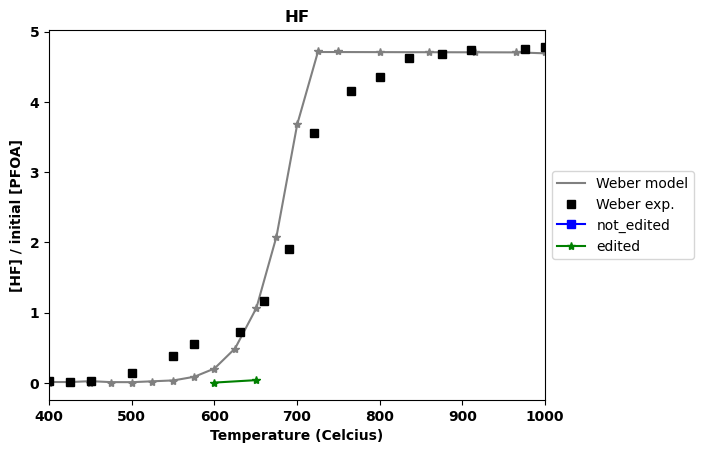

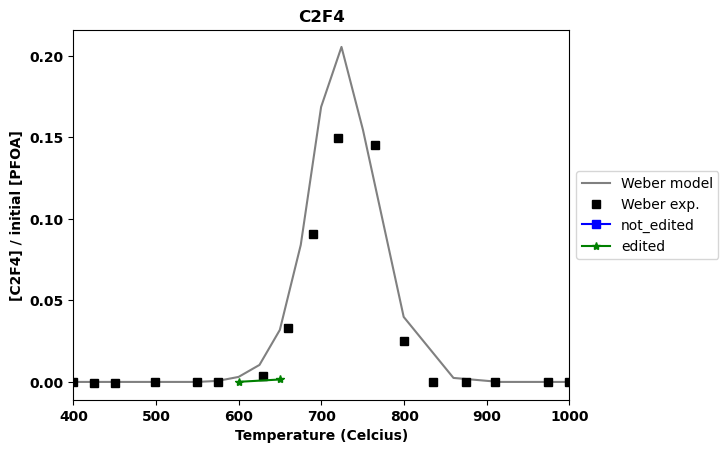

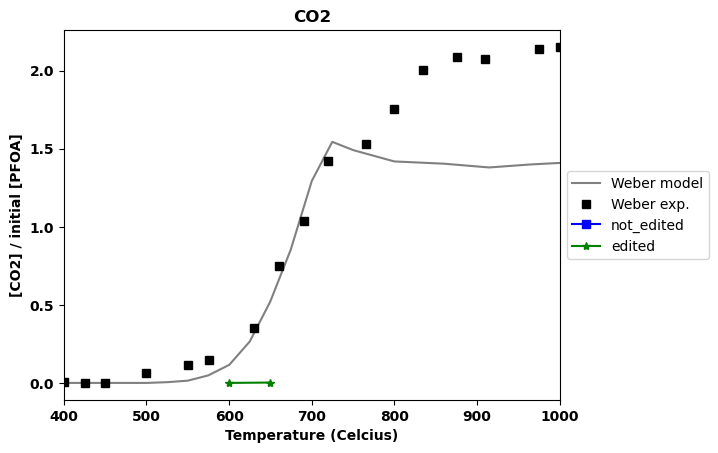

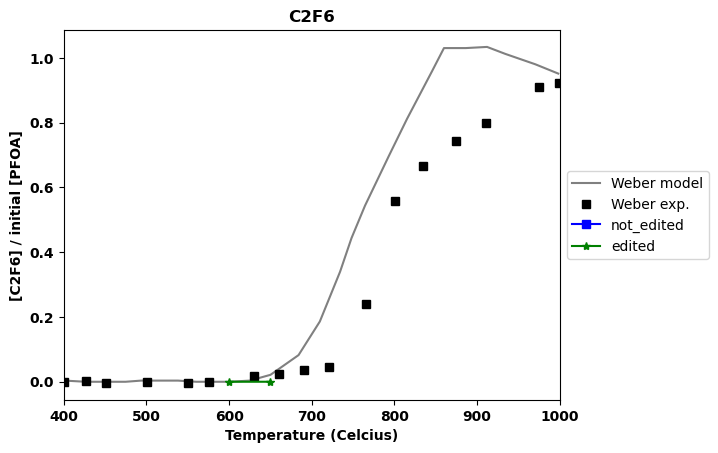

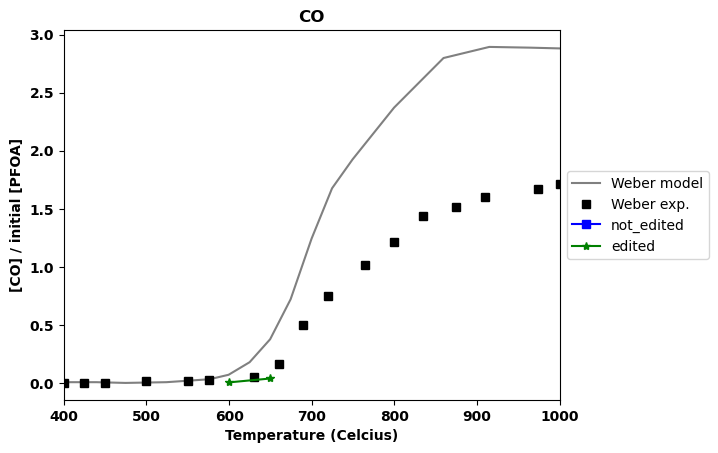

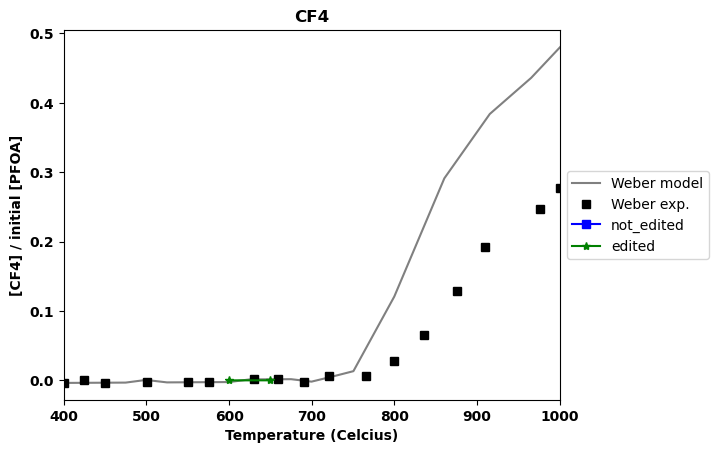

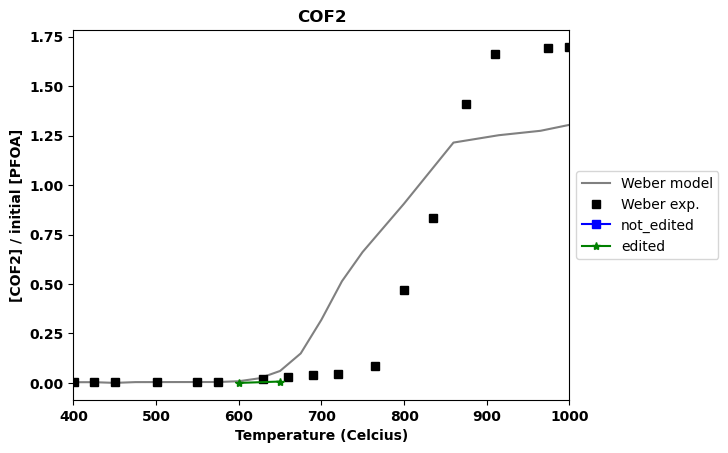

In [10]:
exp_mapping = {'HF(122)': "HF", #key is main names, val in Weber names
               'CF2:CF2(151)': 'C2F4',
               'CO2(13)': 'CO2',
               None: 'CO',
               'CF3-CF3(162)': 'C2F6',
               'CF4(135)': 'CF4',
               'CF2:O(131)': 'COF2'}

convert_species_names_to_main = {'HF(8)': 'HF(122)', #key is fix_reg names, val is main names
                                 'HF(38)': 'HF(122)',
               'CF2CF2(78)': 'CF2:CF2(151)',
                'CF2CF2(61)': 'CF2:CF2(151)',
               'CO2(28)': 'CO2(13)',
               'CO(18)': None, 
                None: 'CF3-CF3(162)',
               #'CF4(135)',
               'CF2O(24)': 'CF2:O(131)'}
    
convert_species_names_to_Weber = {'HF(8)': 'HF', #key is fix_reg names, val is Weber names
                                  'HF(38)': 'HF',
               'CF2CF2(78)': 'C2F4',
               'CO2(28)': 'CO2',
               'CO(18)': 'CO', 
                None: 'CF3-CF3',
               'CF2O(24)': 'COF2'
                                 }

exp_mapping = {'HF(4)': 'HF', 'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}
    
#for master_dictionary_for_concentrations in dictionaries: 
    
#950 is skipped for fix_reg_full_mech
#for spec, item in master_dictionary_sbatch.items(): 
for spec, item in master_dictionary_for_concentrations.items(): 
    print(spec)


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    #exp_data = get_experiment_data(spec)
    #raw_exp_data = get_raw_data_150mLmin(spec)
    exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 
    
    
    weber_raw_data_HF_model = np.array([0, 0.024323, 0.098206, 0.360567, 1.214905, 3.804824, 11.32918, 31.45866, 81.68839, 195.9671, 426.075, 836.8008, 1481.895, 1897.506, 1897.344, 1896.917, 1896.416, 1896.217, 1896.26, 1896.387])/402
    weber_raw_data_temps = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 800, 860, 915, 965, 1000]
    
    if 'HF' in spec: 
        ax1.plot(weber_raw_data_temps, weber_raw_data_HF_model, '*', c='gray')

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    # for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
    #     error_length = raw_error_y - exp_y
    #     # print(error_length)
    #     ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')

    #raw data too
    #ax1.plot(raw_exp_data[0], raw_exp_data[1], '*', mfc='white', markersize=9, c='white', label = 'Weber model') 

   #plot my simulation of Weber's mechanism  
#     ax1.plot(Weber_only_dict[exp_mapping[spec]][0], Weber_only_dict[exp_mapping[spec]][1], '-s', c='red', label='Weber sim.')

    
    
    
    

    #plot tested mechanisms
    mechanisms_tested = ['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms', 'cpn_maxCarbonatoms_seed', 'cpn_seed', 'Weber']
    mechanisms_tested = ['pdep_fix_RAMBlib', 'no_pdep_fix_RAMB', 'Weber sim.', 'main']
    mechanisms_tested = ['not_edited', 'edited']
    #mechanisms_tested = ['RMG', 'Weber']

    colors = ['blue', 'green']#, 'red', 'black']
    markers = ['-s', '-*']# '-d', '-h']
    for [temps, concentrations], mechanism, color, line_marker in zip(item, mechanisms_tested, colors, markers):

        #why is 750 temp so strange? concentrations are huge
        #ax1.plot(temps[:7]+temps[8:],concentrations[:7]+concentrations[8:],'-*', label=mechanism)
        #print(concentrations)
        
        ax1.plot(temps,concentrations,line_marker, color = color, label=mechanism)

    

 
    plt.xlim(400,1000)
    plt.ylabel(f'[{exp_mapping[spec]}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(exp_mapping[spec], fontweight='bold') 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    #plt.legend(bbox_to_anchor=(1.05, 0.5)
    
#with isothermal simulation profile

HF(4)
C2F4(5)
CO2(6)
C2F6(7)
CO(8)
CF4(9)
COF2(10)


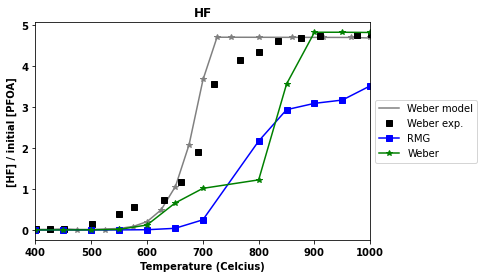

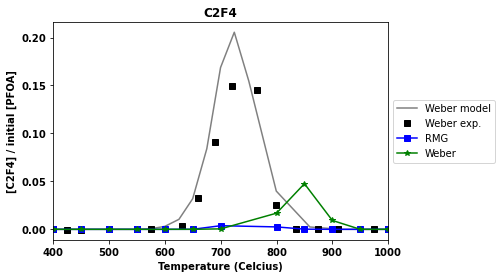

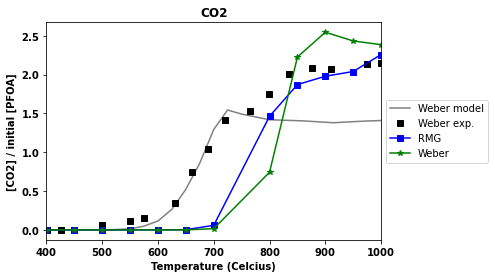

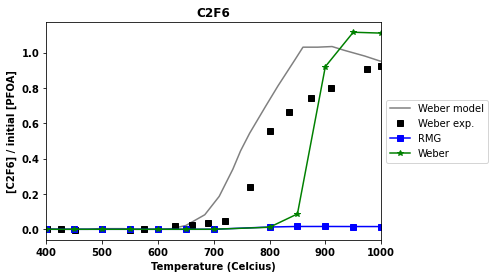

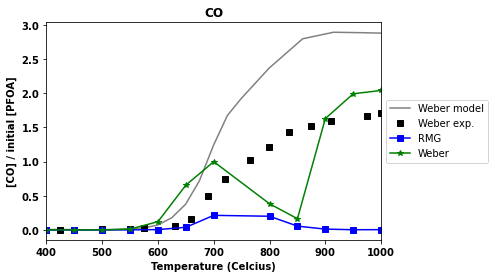

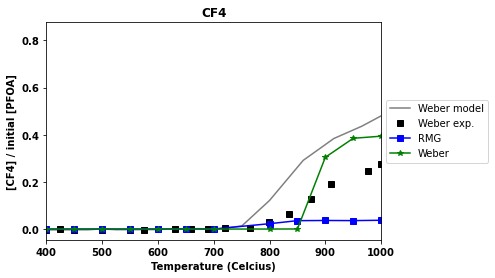

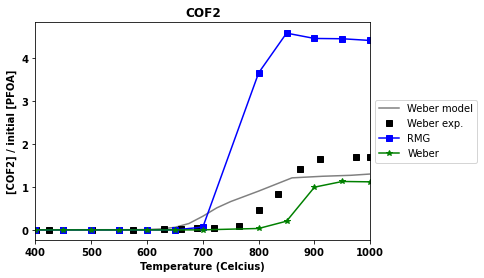

In [23]:
#with actual simulation profile


In [ ]:
exp_mapping = {'HF(122)': "HF", #key is main names, val in Weber names
               'CF2:CF2(151)': 'C2F4',
               'CO2(13)': 'CO2',
               None: 'CO',
               'CF3-CF3(162)': 'C2F6',
               'CF4(135)': 'CF4',
               'CF2:O(131)': 'COF2'}

convert_species_names_to_main = {'HF(8)': 'HF(122)', #key is fix_reg names, val is main names
                                 'HF(38)': 'HF(122)',
               'CF2CF2(78)': 'CF2:CF2(151)',
                'CF2CF2(61)': 'CF2:CF2(151)',
               'CO2(28)': 'CO2(13)',
               'CO(18)': None, 
                None: 'CF3-CF3(162)',
               #'CF4(135)',
               'CF2O(24)': 'CF2:O(131)'}
    
convert_species_names_to_Weber = {'HF(8)': 'HF', #key is fix_reg names, val is Weber names
                                  'HF(38)': 'HF',
               'CF2CF2(78)': 'C2F4',
               'CO2(28)': 'CO2',
               'CO(18)': 'CO', 
                None: 'CF3-CF3',
               'CF2O(24)': 'COF2'
                                 }

exp_mapping = {'HF(4)': 'HF', 'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}
    
#for master_dictionary_for_concentrations in dictionaries: 
    
#950 is skipped for fix_reg_full_mech
#for spec, item in master_dictionary_sbatch.items(): 
for spec, item in master_dictionary_for_concentrations.items(): 
    print(spec)


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    #exp_data = get_experiment_data(spec)
    #raw_exp_data = get_raw_data_150mLmin(spec)
    exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 
    
    
    weber_raw_data_HF_model = np.array([0, 0.024323, 0.098206, 0.360567, 1.214905, 3.804824, 11.32918, 31.45866, 81.68839, 195.9671, 426.075, 836.8008, 1481.895, 1897.506, 1897.344, 1896.917, 1896.416, 1896.217, 1896.26, 1896.387])/402
    weber_raw_data_temps = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 800, 860, 915, 965, 1000]
    
    if 'HF' in spec: 
        ax1.plot(weber_raw_data_temps, weber_raw_data_HF_model, '*', c='gray')

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')

    #raw data too
    #ax1.plot(raw_exp_data[0], raw_exp_data[1], '*', mfc='white', markersize=9, c='white', label = 'Weber model') 

   #plot my simulation of Weber's mechanism  
#     ax1.plot(Weber_only_dict[exp_mapping[spec]][0], Weber_only_dict[exp_mapping[spec]][1], '-s', c='red', label='Weber sim.')

    
    
    
    

    #plot tested mechanisms
    mechanisms_tested = ['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms', 'cpn_maxCarbonatoms_seed', 'cpn_seed', 'Weber']
    mechanisms_tested = ['pdep_fix_RAMBlib', 'no_pdep_fix_RAMB', 'Weber sim.', 'main']
    colors = ['blue', 'orange', 'red', 'black']
    markers = ['-s', '-*', '-d', '-h']
    for [temps, concentrations], mechanism, color, line_marker in zip(item, mechanisms_tested, colors, markers):

        #why is 750 temp so strange? concentrations are huge
        #ax1.plot(temps[:7]+temps[8:],concentrations[:7]+concentrations[8:],'-*', label=mechanism)
        ax1.plot(temps,concentrations,line_marker, color = color, label=mechanism)

    

 
    plt.xlim(400,1000)
    plt.ylabel(f'[{exp_mapping[spec]}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(exp_mapping[spec], fontweight='bold') 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    #plt.legend(bbox_to_anchor=(1.05, 0.5))


In [ ]:
#fresh out of the box...

In [ ]:
#weber 2 CF2 + OH <=> FCO + HF, decreases COF2
#replacing RMG reaction : reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [1.000000e+13, 0.0, 0.0])
#Brown reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [5.39e+10, 0.6, -0.3489484])
reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [8.88e+13, 0.1, 1.006]) #from Weber


In [ ]:
# removal 1, eating up all CF3 which makes C2F6, chebyshev_reaction('O2(2) + CF3(73) (+ M) <=> CF3O2(639) (+ M)',

#weber 2 CF2 + OH <=> FCO + HF, decreases COF2
#replacing RMG reaction : reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [1.000000e+13, 0.0, 0.0])
#Brown reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [5.39e+10, 0.6, -0.3489484])
reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [8.88e+13, 0.1, 1.006]) #from Weber


In [ ]:
###### optimizing HF #################

# removal 1, eating up all CF3 which makes C2F6, chebyshev_reaction('O2(2) + CF3(73) (+ M) <=> CF3O2(639) (+ M)',

#weber 2 CF2 + OH <=> FCO + HF, decreases COF2
#replacing RMG reaction : reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [1.000000e+13, 0.0, 0.0])
#Brown reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [5.39e+10, 0.6, -0.3489484])
reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [8.88e+13, 0.1, 1.006]) #from Weber


##### optimizing C2F6 #############
#weber 3, PW
reaction('CF3(73) + O(25) <=> COF2(10) + F(19)', [3.130000e+11, 0.0, -4.6640]) #replacing rmg reaction('O(25) + CF3(73) <=> F(19) + COF2(10)', [1.540000e+13, 0.0, 0.0]) from 2-BTP


#weber 4, increases C2F6 greatly. He used similar parameters but decreased to a negative Ea ?
# Reaction 30
falloff_reaction('CF3(73) + CF3(73) (+ M) <=> C2F6(7) (+ M)',
                 kf=[9.690000e+10, 1.0, -2.7800],
                 kf0=[1.490000e+60, -12.51, 5.9100],
                 falloff=Troe(A=0.069, T3=260.0, T1=880.0))

#weber 5
reaction('CF3-CF2(221) + F(19) <=> C2F6(7)', [1.37e+12, 0, 0.326]) #from Weber, replacing RMG chebyshev_reaction('C2F6(7) (+ M) <=> F(19) + CF3-CF2(221) (+ M)', from pdep #115


In [ ]:

###### optimizing HF #################

# removal 1, eating up all CF3 which makes C2F6, chebyshev_reaction('O2(2) + CF3(73) (+ M) <=> CF3O2(639) (+ M)',

#weber 2 CF2 + OH <=> FCO + HF, decreases COF2
#replacing RMG reaction : reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [1.000000e+13, 0.0, 0.0])
#Brown reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [5.39e+10, 0.6, -0.3489484])
reaction('OH(26) + CF2(15) <=> HF(4) + FCO(24)', [8.88e+13, 0.1, 1.006]) #from Weber



##### optimizing C2F6 #############

#weber 4, increases C2F6 greatly. He used similar parameters but decreased to a negative Ea ?
# Reaction 30
falloff_reaction('CF3(73) + CF3(73) (+ M) <=> C2F6(7) (+ M)',
                 kf=[9.690000e+10, 1.0, -2.7800],
                 kf0=[1.490000e+60, -12.51, 5.9100],
                 falloff=Troe(A=0.069, T3=260.0, T1=880.0))

#weber 5
reaction('CF3-CF2(221) + F(19) <=> C2F6(7)', [1.37e+12, 0, 0.326]) #from Weber, replacing RMG chebyshev_reaction('C2F6(7) (+ M) <=> F(19) + CF3-CF2(221) (+ M)', from pdep #115



In [ ]:
exp_mapping = {'HF(122)': "HF", #key is main names, val in Weber names
               'CF2:CF2(151)': 'C2F4',
               'CO2(13)': 'CO2',
               None: 'CO',
               'CF3-CF3(162)': 'C2F6',
               'CF4(135)': 'CF4',
               'CF2:O(131)': 'COF2'}

convert_species_names_to_main = {'HF(8)': 'HF(122)', #key is fix_reg names, val is main names
                                 'HF(38)': 'HF(122)',
               'CF2CF2(78)': 'CF2:CF2(151)',
                'CF2CF2(61)': 'CF2:CF2(151)',
               'CO2(28)': 'CO2(13)',
               'CO(18)': None, 
                None: 'CF3-CF3(162)',
               #'CF4(135)',
               'CF2O(24)': 'CF2:O(131)'}
    
convert_species_names_to_Weber = {'HF(8)': 'HF', #key is fix_reg names, val is Weber names
                                  'HF(38)': 'HF',
               'CF2CF2(78)': 'C2F4',
               'CO2(28)': 'CO2',
               'CO(18)': 'CO', 
                None: 'CF3-CF3',
               'CF2O(24)': 'COF2'
                                 }

exp_mapping = {'HF(4)': 'HF', 'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}
    
#for master_dictionary_for_concentrations in dictionaries: 
    
#950 is skipped for fix_reg_full_mech
#for spec, item in master_dictionary_sbatch.items(): 
for spec, item in master_dictionary_for_concentrations.items(): 
    print(spec)


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    #exp_data = get_experiment_data(spec)
    #raw_exp_data = get_raw_data_150mLmin(spec)
    exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 
    
    
    weber_raw_data_HF_model = np.array([0, 0.024323, 0.098206, 0.360567, 1.214905, 3.804824, 11.32918, 31.45866, 81.68839, 195.9671, 426.075, 836.8008, 1481.895, 1897.506, 1897.344, 1896.917, 1896.416, 1896.217, 1896.26, 1896.387])/402
    weber_raw_data_temps = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 800, 860, 915, 965, 1000]
    
    if 'HF' in spec: 
        ax1.plot(weber_raw_data_temps, weber_raw_data_HF_model, '*', c='gray')

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')

    #raw data too
    #ax1.plot(raw_exp_data[0], raw_exp_data[1], '*', mfc='white', markersize=9, c='white', label = 'Weber model') 

   #plot my simulation of Weber's mechanism  
#     ax1.plot(Weber_only_dict[exp_mapping[spec]][0], Weber_only_dict[exp_mapping[spec]][1], '-s', c='red', label='Weber sim.')

    
    
    
    

    #plot tested mechanisms
    mechanisms_tested = ['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms', 'cpn_maxCarbonatoms_seed', 'cpn_seed', 'Weber']
    mechanisms_tested = ['pdep_fix_RAMBlib', 'no_pdep_fix_RAMB', 'Weber sim.', 'main']
    colors = ['blue', 'orange', 'red', 'black']
    markers = ['-s', '-*', '-d', '-h']
    for [temps, concentrations], mechanism, color, line_marker in zip(item, mechanisms_tested, colors, markers):

        #why is 750 temp so strange? concentrations are huge
        #ax1.plot(temps[:7]+temps[8:],concentrations[:7]+concentrations[8:],'-*', label=mechanism)
        ax1.plot(temps,concentrations,line_marker, color = color, label=mechanism)

    

 
    plt.xlim(400,1000)
    plt.ylabel(f'[{exp_mapping[spec]}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(exp_mapping[spec], fontweight='bold') 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    #plt.legend(bbox_to_anchor=(1.05, 0.5))


In [ ]:
exp_mapping = {'HF(122)': "HF", #key is main names, val in Weber names
               'CF2:CF2(151)': 'C2F4',
               'CO2(13)': 'CO2',
               None: 'CO',
               'CF3-CF3(162)': 'C2F6',
               'CF4(135)': 'CF4',
               'CF2:O(131)': 'COF2'}

convert_species_names_to_main = {'HF(8)': 'HF(122)', #key is fix_reg names, val is main names
                                 'HF(38)': 'HF(122)',
               'CF2CF2(78)': 'CF2:CF2(151)',
                'CF2CF2(61)': 'CF2:CF2(151)',
               'CO2(28)': 'CO2(13)',
               'CO(18)': None, 
                None: 'CF3-CF3(162)',
               #'CF4(135)',
               'CF2O(24)': 'CF2:O(131)'}
    
convert_species_names_to_Weber = {'HF(8)': 'HF', #key is fix_reg names, val is Weber names
                                  'HF(38)': 'HF',
               'CF2CF2(78)': 'C2F4',
               'CO2(28)': 'CO2',
               'CO(18)': 'CO', 
                None: 'CF3-CF3',
               'CF2O(24)': 'COF2'
                                 }

exp_mapping = {'HF(4)': 'HF', 'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}
    
#for master_dictionary_for_concentrations in dictionaries: 
    
#950 is skipped for fix_reg_full_mech
#for spec, item in master_dictionary_sbatch.items(): 
for spec, item in master_dictionary_for_concentrations.items(): 
    print(spec)


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    #exp_data = get_experiment_data(spec)
    #raw_exp_data = get_raw_data_150mLmin(spec)
    exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 
    
    
    weber_raw_data_HF_model = np.array([0, 0.024323, 0.098206, 0.360567, 1.214905, 3.804824, 11.32918, 31.45866, 81.68839, 195.9671, 426.075, 836.8008, 1481.895, 1897.506, 1897.344, 1896.917, 1896.416, 1896.217, 1896.26, 1896.387])/402
    weber_raw_data_temps = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 800, 860, 915, 965, 1000]
    
    if 'HF' in spec: 
        ax1.plot(weber_raw_data_temps, weber_raw_data_HF_model, '*', c='gray')

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')

    #raw data too
    #ax1.plot(raw_exp_data[0], raw_exp_data[1], '*', mfc='white', markersize=9, c='white', label = 'Weber model') 

   #plot my simulation of Weber's mechanism  
#     ax1.plot(Weber_only_dict[exp_mapping[spec]][0], Weber_only_dict[exp_mapping[spec]][1], '-s', c='red', label='Weber sim.')

    
    
    
    

    #plot tested mechanisms
    mechanisms_tested = ['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms', 'cpn_maxCarbonatoms_seed', 'cpn_seed', 'Weber']
    mechanisms_tested = ['pdep_fix_RAMBlib', 'no_pdep_fix_RAMB', 'Weber sim.', 'main']
    colors = ['blue', 'orange', 'red', 'black']
    markers = ['-s', '-*', '-d', '-h']
    for [temps, concentrations], mechanism, color, line_marker in zip(item, mechanisms_tested, colors, markers):

        #why is 750 temp so strange? concentrations are huge
        #ax1.plot(temps[:7]+temps[8:],concentrations[:7]+concentrations[8:],'-*', label=mechanism)
        ax1.plot(temps,concentrations,line_marker, color = color, label=mechanism)

    

 
    plt.xlim(400,1000)
    plt.ylabel(f'[{exp_mapping[spec]}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(exp_mapping[spec], fontweight='bold') 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    #plt.legend(bbox_to_anchor=(1.05, 0.5))


In [ ]:
exp_mapping = {'HF(122)': "HF", #key is main names, val in Weber names
               'CF2:CF2(151)': 'C2F4',
               'CO2(13)': 'CO2',
               None: 'CO',
               'CF3-CF3(162)': 'C2F6',
               'CF4(135)': 'CF4',
               'CF2:O(131)': 'COF2'}

convert_species_names_to_main = {'HF(8)': 'HF(122)', #key is fix_reg names, val is main names
                                 'HF(38)': 'HF(122)',
               'CF2CF2(78)': 'CF2:CF2(151)',
                'CF2CF2(61)': 'CF2:CF2(151)',
               'CO2(28)': 'CO2(13)',
               'CO(18)': None, 
                None: 'CF3-CF3(162)',
               #'CF4(135)',
               'CF2O(24)': 'CF2:O(131)'}
    
convert_species_names_to_Weber = {'HF(8)': 'HF', #key is fix_reg names, val is Weber names
                                  'HF(38)': 'HF',
               'CF2CF2(78)': 'C2F4',
               'CO2(28)': 'CO2',
               'CO(18)': 'CO', 
                None: 'CF3-CF3',
               'CF2O(24)': 'COF2'
                                 }

exp_mapping = {'HF(4)': 'HF', 'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}
    
#for master_dictionary_for_concentrations in dictionaries: 
    
#950 is skipped for fix_reg_full_mech
#for spec, item in master_dictionary_sbatch.items(): 
for spec, item in master_dictionary_for_concentrations.items(): 
    print(spec)


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    #exp_data = get_experiment_data(spec)
    #raw_exp_data = get_raw_data_150mLmin(spec)
    exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 
    
    
    weber_raw_data_HF_model = np.array([0, 0.024323, 0.098206, 0.360567, 1.214905, 3.804824, 11.32918, 31.45866, 81.68839, 195.9671, 426.075, 836.8008, 1481.895, 1897.506, 1897.344, 1896.917, 1896.416, 1896.217, 1896.26, 1896.387])/402
    weber_raw_data_temps = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 800, 860, 915, 965, 1000]
    
    if 'HF' in spec: 
        ax1.plot(weber_raw_data_temps, weber_raw_data_HF_model, '*', c='gray')

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')

    #raw data too
    #ax1.plot(raw_exp_data[0], raw_exp_data[1], '*', mfc='white', markersize=9, c='white', label = 'Weber model') 

   #plot my simulation of Weber's mechanism  
#     ax1.plot(Weber_only_dict[exp_mapping[spec]][0], Weber_only_dict[exp_mapping[spec]][1], '-s', c='red', label='Weber sim.')

    
    
    
    

    #plot tested mechanisms
    mechanisms_tested = ['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms', 'cpn_maxCarbonatoms_seed', 'cpn_seed', 'Weber']
    mechanisms_tested = ['pdep_fix_RAMBlib', 'no_pdep_fix_RAMB', 'Weber sim.', 'main']
    colors = ['blue', 'orange', 'red', 'black']
    markers = ['-s', '-*', '-d', '-h']
    for [temps, concentrations], mechanism, color, line_marker in zip(item, mechanisms_tested, colors, markers):

        #why is 750 temp so strange? concentrations are huge
        #ax1.plot(temps[:7]+temps[8:],concentrations[:7]+concentrations[8:],'-*', label=mechanism)
        ax1.plot(temps,concentrations,line_marker, color = color, label=mechanism)

    

 
    plt.xlim(400,1000)
    plt.ylabel(f'[{exp_mapping[spec]}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(exp_mapping[spec], fontweight='bold') 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    #plt.legend(bbox_to_anchor=(1.05, 0.5))
#model_paths = [full_path+'/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/RAMB_forbidden_groups/no_pdep_dup_fix/chemkin/copies/copy_chem0291.cti']


In [ ]:

#model_paths = ['/projects/westgroup/nora/Code/projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/RAMB_forbidden_groups/pdep_dup_fix/chemkin/copies/copy_chem0303.cti']


In [ ]:
#SYNC 

exp_mapping = {'HF(122)': "HF", #key is main names, val in Weber names
               'CF2:CF2(151)': 'C2F4',
               'CO2(13)': 'CO2',
               None: 'CO',
               'CF3-CF3(162)': 'C2F6',
               'CF4(135)': 'CF4',
               'CF2:O(131)': 'COF2'}

convert_species_names_to_main = {'HF(8)': 'HF(122)', #key is fix_reg names, val is main names
                                 'HF(38)': 'HF(122)',
               'CF2CF2(78)': 'CF2:CF2(151)',
                'CF2CF2(61)': 'CF2:CF2(151)',
               'CO2(28)': 'CO2(13)',
               'CO(18)': None, 
                None: 'CF3-CF3(162)',
               #'CF4(135)',
               'CF2O(24)': 'CF2:O(131)'}
    
convert_species_names_to_Weber = {'HF(8)': 'HF', #key is fix_reg names, val is Weber names
                                  'HF(38)': 'HF',
               'CF2CF2(78)': 'C2F4',
               'CO2(28)': 'CO2',
               'CO(18)': 'CO', 
                None: 'CF3-CF3',
               'CF2O(24)': 'COF2'
                                 }

exp_mapping = {'HF(4)': 'HF', 'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}
    
#for master_dictionary_for_concentrations in dictionaries: 
    
#950 is skipped for fix_reg_full_mech
#for spec, item in master_dictionary_sbatch.items(): 
for spec, item in master_dictionary_for_concentrations_sync.items(): 
    print(spec)


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    #exp_data = get_experiment_data(spec)
    #raw_exp_data = get_raw_data_150mLmin(spec)
    exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 
    
    
    weber_raw_data_HF_model = np.array([0, 0.024323, 0.098206, 0.360567, 1.214905, 3.804824, 11.32918, 31.45866, 81.68839, 195.9671, 426.075, 836.8008, 1481.895, 1897.506, 1897.344, 1896.917, 1896.416, 1896.217, 1896.26, 1896.387])/402
    weber_raw_data_temps = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 800, 860, 915, 965, 1000]
    
    if 'HF' in spec: 
        ax1.plot(weber_raw_data_temps, weber_raw_data_HF_model, '*', c='gray')

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')

    #raw data too
    #ax1.plot(raw_exp_data[0], raw_exp_data[1], '*', mfc='white', markersize=9, c='white', label = 'Weber model') 


    #plot tested mechanisms
    mechanisms_tested = ['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms', 'cpn_maxCarbonatoms_seed', 'cpn_seed', 'Weber']
    mechanisms_tested = ['RMG fg', 'Weber']
    for [temps, concentrations], mechanism  in zip(item, mechanisms_tested):

        #why is 750 temp so strange? concentrations are huge
        #ax1.plot(temps[:7]+temps[8:],concentrations[:7]+concentrations[8:],'-*', label=mechanism)
        ax1.plot(temps,concentrations,'-*', label=mechanism)

 
    plt.xlim(400,1000)
    plt.ylabel(f'[{spec}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(spec, fontweight='bold') 
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    plt.legend(bbox_to_anchor=(1.05, 0.5))

In [ ]:
#model_paths = [full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/pdep_duplicates_fix/pdep_fix/chemkin/copies/copy_chem0225.cti']


In [ ]:
 

exp_mapping = {'HF(122)': "HF", #key is main names, val in Weber names
               'CF2:CF2(151)': 'C2F4',
               'CO2(13)': 'CO2',
               None: 'CO',
               'CF3-CF3(162)': 'C2F6',
               'CF4(135)': 'CF4',
               'CF2:O(131)': 'COF2'}

convert_species_names_to_main = {'HF(8)': 'HF(122)', #key is fix_reg names, val is main names
                                 'HF(38)': 'HF(122)',
               'CF2CF2(78)': 'CF2:CF2(151)',
                'CF2CF2(61)': 'CF2:CF2(151)',
               'CO2(28)': 'CO2(13)',
               'CO(18)': None, 
                None: 'CF3-CF3(162)',
               #'CF4(135)',
               'CF2O(24)': 'CF2:O(131)'}
    
convert_species_names_to_Weber = {'HF(8)': 'HF', #key is fix_reg names, val is Weber names
                                  'HF(38)': 'HF',
               'CF2CF2(78)': 'C2F4',
               'CO2(28)': 'CO2',
               'CO(18)': 'CO', 
                None: 'CF3-CF3',
               'CF2O(24)': 'COF2'
                                 }

exp_mapping = {'HF(4)': 'HF', 'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}
    
#for master_dictionary_for_concentrations in dictionaries: 
    
#950 is skipped for fix_reg_full_mech
#for spec, item in master_dictionary_sbatch.items(): 
for spec, item in master_dictionary_for_concentrations.items(): 
    print(spec)


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    #exp_data = get_experiment_data(spec)
    #raw_exp_data = get_raw_data_150mLmin(spec)
    exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 
    
    
    weber_raw_data_HF_model = np.array([0, 0.024323, 0.098206, 0.360567, 1.214905, 3.804824, 11.32918, 31.45866, 81.68839, 195.9671, 426.075, 836.8008, 1481.895, 1897.506, 1897.344, 1896.917, 1896.416, 1896.217, 1896.26, 1896.387])/402
    weber_raw_data_temps = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 800, 860, 915, 965, 1000]
    
    if 'HF' in spec: 
        ax1.plot(weber_raw_data_temps, weber_raw_data_HF_model, '*', c='gray')

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')

    #raw data too
    #ax1.plot(raw_exp_data[0], raw_exp_data[1], '*', mfc='white', markersize=9, c='white', label = 'Weber model') 


    #plot tested mechanisms
    mechanisms_tested = ['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms', 'cpn_maxCarbonatoms_seed', 'cpn_seed', 'Weber']
    mechanisms_tested = ['RMG fg', 'Weber']
    for [temps, concentrations], mechanism  in zip(item, mechanisms_tested):

        #why is 750 temp so strange? concentrations are huge
        #ax1.plot(temps[:7]+temps[8:],concentrations[:7]+concentrations[8:],'-*', label=mechanism)
        ax1.plot(temps,concentrations,'-*', label=mechanism)

 
    plt.xlim(400,1000)
    plt.ylabel(f'[{spec}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(spec, fontweight='bold') 
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    plt.legend(bbox_to_anchor=(1.05, 0.5))

In [ ]:
for key, val in master_dictionary_for_concentrations.items():
    [temps, conc] = val[0]
    print(f'*************{key}************')
    for t, c in zip(temps, conc):
        print(t,c)

In [ ]:
for key, val in master_dictionary_for_concentrations.items():
    [temps, conc] = val[0]
    print(f'*************{key}************')
    for t, c in zip(temps, conc):
        print(t,c)

In [ ]:
 

exp_mapping = {'HF(122)': "HF", #key is main names, val in Weber names
               'CF2:CF2(151)': 'C2F4',
               'CO2(13)': 'CO2',
               None: 'CO',
               'CF3-CF3(162)': 'C2F6',
               'CF4(135)': 'CF4',
               'CF2:O(131)': 'COF2'}

convert_species_names_to_main = {'HF(8)': 'HF(122)', #key is fix_reg names, val is main names
                                 'HF(38)': 'HF(122)',
               'CF2CF2(78)': 'CF2:CF2(151)',
                'CF2CF2(61)': 'CF2:CF2(151)',
               'CO2(28)': 'CO2(13)',
               'CO(18)': None, 
                None: 'CF3-CF3(162)',
               #'CF4(135)',
               'CF2O(24)': 'CF2:O(131)'}
    
convert_species_names_to_Weber = {'HF(8)': 'HF', #key is fix_reg names, val is Weber names
                                  'HF(38)': 'HF',
               'CF2CF2(78)': 'C2F4',
               'CO2(28)': 'CO2',
               'CO(18)': 'CO', 
                None: 'CF3-CF3',
               'CF2O(24)': 'COF2'
                                 }

exp_mapping = {'HF(4)': 'HF', 'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}
    
#for master_dictionary_for_concentrations in dictionaries: 
    
#950 is skipped for fix_reg_full_mech
#for spec, item in master_dictionary_sbatch.items(): 
for spec, item in master_dictionary_for_concentrations.items(): 
    print(spec)


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    #exp_data = get_experiment_data(spec)
    #raw_exp_data = get_raw_data_150mLmin(spec)
    exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 
    
    
    weber_raw_data_HF_model = np.array([0, 0.024323, 0.098206, 0.360567, 1.214905, 3.804824, 11.32918, 31.45866, 81.68839, 195.9671, 426.075, 836.8008, 1481.895, 1897.506, 1897.344, 1896.917, 1896.416, 1896.217, 1896.26, 1896.387])/402
    weber_raw_data_temps = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 800, 860, 915, 965, 1000]
    
    if 'HF' in spec: 
        ax1.plot(weber_raw_data_temps, weber_raw_data_HF_model, '*', c='gray')

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')

    #raw data too
    #ax1.plot(raw_exp_data[0], raw_exp_data[1], '*', mfc='white', markersize=9, c='white', label = 'Weber model') 


    #plot tested mechanisms
    mechanisms_tested = ['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms', 'cpn_maxCarbonatoms_seed', 'cpn_seed', 'Weber']
    mechanisms_tested = ['RMG fg', 'Weber']
    for [temps, concentrations], mechanism  in zip(item, mechanisms_tested):

        #why is 750 temp so strange? concentrations are huge
        #ax1.plot(temps[:7]+temps[8:],concentrations[:7]+concentrations[8:],'-*', label=mechanism)
        ax1.plot(temps,concentrations,'-*', label=mechanism)

 
    plt.xlim(400,1000)
    plt.ylabel(f'[{spec}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(spec, fontweight='bold') 
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    plt.legend(bbox_to_anchor=(1.05, 0.5))

In [ ]:
for key, val in master_dictionary_for_concentrations.items():
    [temps, conc] = val[0]
    print(f'*************{key}************')
    for t, c in zip(temps, conc):
        print(t,c)

In [ ]:
for key, val in master_dictionary_for_concentrations.items():
    [temps, conc] = val[0]
    print(f'*************{key}************')
    for t, c in zip(temps, conc):
        print(t,c)

In [ ]:
for key, val in master_dictionary_for_concentrations.items():
    [temps, conc] = val[0]
    print(f'*************{key}************')
    for t, c in zip(temps, conc):
        print(t,c)

In [ ]:
for key, val in master_dictionary_for_concentrations.items():
    [temps, conc] = val[0]
    print(f'*************{key}************')
    for t, c in zip(temps, conc):
        print(t,c)

In [ ]:
for key, val in master_dictionary_for_concentrations.items():
    [temps, conc] = val[0]
    print(f'*************{key}************')
    for t, c in zip(temps, conc):
        print(t,c)

In [ ]:
for key, val in master_dictionary_for_concentrations.items():
    [temps, conc] = val[0]
    print(f'*************{key}************')
    for t, c in zip(temps, conc):
        print(t,c)
        

In [ ]:
val

In [ ]:
master_dictionary_for_concentrations['HF(4)'] 

In [ ]:
master_dictionary_for_concentrations['HF(4)'] 

In [ ]:
file_path = "./all_mechs_cor_isothermal.json" #actually has the custom T profiles

with open(file_path, 'r') as file:
    all_mechs_isothermal_cor_dict = json.load(file)            

exp_mapping = {'HF(122)': "HF", #key is main names, val in Weber names
               'CF2:CF2(151)': 'C2F4',
               'CO2(13)': 'CO2',
               None: 'CO',
               'CF3-CF3(162)': 'C2F6',
               'CF4(135)': 'CF4',
               'CF2:O(131)': 'COF2'}

convert_species_names_to_main = {'HF(8)': 'HF(122)', #key is fix_reg names, val is main names
                                 'HF(38)': 'HF(122)',
               'CF2CF2(78)': 'CF2:CF2(151)',
                'CF2CF2(61)': 'CF2:CF2(151)',
               'CO2(28)': 'CO2(13)',
               'CO(18)': None, 
                None: 'CF3-CF3(162)',
               #'CF4(135)',
               'CF2O(24)': 'CF2:O(131)'}
    
convert_species_names_to_Weber = {'HF(8)': 'HF', #key is fix_reg names, val is Weber names
                                  'HF(38)': 'HF',
               'CF2CF2(78)': 'C2F4',
               'CO2(28)': 'CO2',
               'CO(18)': 'CO', 
                None: 'CF3-CF3',
               'CF2O(24)': 'COF2'
                                 }

exp_mapping = {'HF(4)': 'HF', 'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}
    
#for master_dictionary_for_concentrations in dictionaries: 
    
#950 is skipped for fix_reg_full_mech
#for spec, item in master_dictionary_sbatch.items(): 

for spec, item in master_dictionary_for_concentrations.items(): 
    print(spec)


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    #exp_data = get_experiment_data(spec)
    #raw_exp_data = get_raw_data_150mLmin(spec)
    exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 
    
    
    weber_raw_data_HF_model = np.array([0, 0.024323, 0.098206, 0.360567, 1.214905, 3.804824, 11.32918, 31.45866, 81.68839, 195.9671, 426.075, 836.8008, 1481.895, 1897.506, 1897.344, 1896.917, 1896.416, 1896.217, 1896.26, 1896.387])/402
    weber_raw_data_temps = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 800, 860, 915, 965, 1000]
    
    if 'HF' in spec: 
        ax1.plot(weber_raw_data_temps, weber_raw_data_HF_model, '*', c='gray')

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')

    #raw data too
    #ax1.plot(raw_exp_data[0], raw_exp_data[1], '*', mfc='white', markersize=9, c='white', label = 'Weber model') 


    #plot tested mechanisms
    mechanisms_tested = ['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms', 'cpn_maxCarbonatoms_seed', 'cpn_seed', 'Weber']
    mechanisms_tested = ['RMG fg', 'Weber']
    for [temps, concentrations], mechanism  in zip(item, mechanisms_tested):

        #why is 750 temp so strange? concentrations are huge
        #ax1.plot(temps[:7]+temps[8:],concentrations[:7]+concentrations[8:],'-*', label=mechanism)
        ax1.plot(temps,concentrations,'-*', label=mechanism)

    for (spec_isothermal_cor, item_isothermal_cor) in zip(all_mechs_isothermal_cor_dict.items()): 
        
        
     
 
    plt.xlim(400,1000)
    plt.ylabel(f'[{spec}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(spec, fontweight='bold') 
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    plt.legend(bbox_to_anchor=(1.05, 0.5))

In [ ]:
master_dictionary_for_concentrations['HF(4)'] 

In [ ]:
master_dictionary_for_concentrations['HF(4)'] 

In [ ]:
master_dictionary_for_concentrations['HF(4)'] 

In [ ]:
master_dictionary_for_concentrations['HF(4)'] 

In [ ]:
master_dictionary_for_concentrations['HF(4)'] 

In [ ]:
master_dictionary_for_concentrations['HF(4)'] 

In [ ]:
master_dictionary_for_concentrations['HF(4)'] #to see if its moving 

In [ ]:
all_temperatures = range(400,1150, 50)
# all_temperatures = [1000]
        
fig = plt.figure()
ax1 = fig.add_subplot(111)

exp_mapping = {'HF(122)': "HF", #key is main names, val in Weber names
               'CF2:CF2(151)': 'C2F4',
               'CO2(13)': 'CO2',
               None: 'CO',
               'CF3-CF3(162)': 'C2F6',
               'CF4(135)': 'CF4',
               'CF2:O(131)': 'COF2'}

convert_species_names_to_main = {'HF(8)': 'HF(122)', #key is fix_reg names, val is main names
                                 'HF(38)': 'HF(122)',
               'CF2CF2(78)': 'CF2:CF2(151)',
                'CF2CF2(61)': 'CF2:CF2(151)',
               'CO2(28)': 'CO2(13)',
               'CO(18)': None, 
                None: 'CF3-CF3(162)',
               #'CF4(135)',
               'CF2O(24)': 'CF2:O(131)'}
    
convert_species_names_to_Weber = {'HF(8)': 'HF', #key is fix_reg names, val is Weber names
                                  'HF(38)': 'HF',
               'CF2CF2(78)': 'C2F4',
               'CO2(28)': 'CO2',
               'CO(18)': 'CO', 
                None: 'CF3-CF3',
               'CF2O(24)': 'COF2'
                                 }

exp_mapping = {'HF(4)': 'HF', 
               'HF(122)': 'HF',
               'C2F4(5)': 'C2F4', 
               'CO2(6)': 'CO2', 
               'C2F6(7)': 'C2F6', 
               'CO(8)': 'CO', 
               'CF4(9)': 'CF4', 
               'COF2(10)': 'COF2'}
    
#for master_dictionary_for_concentrations in dictionaries: 
    
#950 is skipped for fix_reg_full_mech
#for spec, item in master_dictionary_sbatch.items(): 

for spec, item in master_dictionary_for_concentrations.items(): 
    print(spec)


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    #exp_data = get_experiment_data(spec)
    raw_exp_data = get_raw_data_150mLmin(exp_mapping[spec])
    exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber (from publication)') 
    
    
    #compare to weber simulation 
    temperatures_weber_sim, concentrations_weber_sim =  all_mechs_isothermal_across_all_temps_COR[exp_mapping[spec]][-1]
    #ax1.plot(temperatures_weber_sim, concentrations_weber_sim, '-', c='orange', label = 'Weber simulation') 

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')

    #raw data too
    #ax1.plot(raw_exp_data[0], raw_exp_data[1], '*', mfc='gray', markersize=9, c='gray') 


    #plot tested mechanisms
    mechanisms_tested = ['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms', 'cpn_maxCarbonatoms_seed', 'cpn_seed', 'Weber']
    mechanisms_tested = ['Weber_GPT', 'Weber']
    mechanisms_tested = ['RMG (FGs, C7F14 in core)']
    for [temps, concentrations], mechanism  in zip(item, mechanisms_tested):

        #why is 750 temp so strange? concentrations are huge
        #ax1.plot(temps[:7]+temps[8:],concentrations[:7]+concentrations[8:],'-*', label=mechanism)
        ax1.plot(temps,concentrations,'-*', label='rmg (main)')

 
    plt.xlim(400,1000)
    plt.ylabel(f'[{spec}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(spec, fontweight='bold') 
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    plt.legend(bbox_to_anchor=(2.05, 0.5))

In [ ]:
print(master_dictionary_for_concentrations.values())
#for reference to see if values are moving at all?

Get sensitivities to HF for "main" model and "seed" model 

In [ ]:
for rxn in gas.reactions():
    should_have = ['HF(4)', 'CHO2(300)']
    if 'PFOA(1)' in rxn.reactants.keys() or 'PFOA(1)' in rxn.products.keys():
        if not any(spec in rxn.reactants.keys() or spec in rxn.products.keys() for spec in should_have): 
            print(f'EXCLUDING {rxn}')
        else:
            print(f'keeping {rxn}')

In [ ]:
temp = 800
print(model_path)
states_main, gas_main, sens_data_main = run_edited_mech_sim(temp, model_path, calculate_sensitivities=True)

In [ ]:
sorted_sens_main = sens_data_main.sort(key=lambda x: float(x[0]), reverse=True)

In [ ]:
with open('sens_data_forbidden_group.txt', 'w') as f: 
    f.write(str(sens_data_main))

In [ ]:
sens_data_main.sort(key=lambda x: float(x[0]), reverse=True)

In [ ]:
for (sens, equation) in sens_data_main: 
    print(sens, equation)

In [ ]:
mech = 'cpn_seed'
temp = 800
states_seed, gas_seed, sens_data_seed = run_sim(temp, mech, calculate_sensitivities=True)

In [ ]:
sens_data_seed.sort(key=lambda x: float(x[0]), reverse=True)
print(sens_data_seed)

# Final Plots

In [ ]:
#comparing Weber chain of reactors versus Weber non-chain to show that simulation results are the same


all_temperatures = range(400,1150, 50)
# all_temperatures = [1000]

def get_experiment_data(exp_label):
        
    spec_data=pd.read_csv(f'./literature_data/{exp_label}.csv')
        
    exp_data = {}
    for header in ['model', 'experiments', 'error']:
        index_of_x = spec_data.columns.get_loc(header)
        index_of_y = index_of_x+1 

        x_values_raw = spec_data.iloc[:, index_of_x]
        x_values = [float(x) for x in x_values_raw[1:]] #removes first header of 'X' or 'Y'
    
        y_values_raw = spec_data.iloc[:, index_of_y]
        y_values = [float(x) for x in y_values_raw[1:]]
        
        exp_data[header]=(x_values, y_values)
        
        
    return exp_data
        
fig = plt.figure()
ax1 = fig.add_subplot(111)



for (spec_cor, item_cor), (spec_or, item_or) in zip(web_cor.items(), web_or.items()): 


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    exp_data = get_experiment_data(spec_cor)
    #exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')



    #plot tested mechanisms
    for [temps_cor, concentrations_cor], [temps_or, concentrations_or]  in zip(item_cor, item_or):

        ax1.plot(temps_cor,concentrations_cor,'-*', label='COR')
        ax1.plot(temps_or,concentrations_or,'-*', label="OR")

    #also 
        
        
        
        
    plt.xlim(400,1000)
    plt.ylabel(f'[{spec_cor}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(spec_cor, fontweight='bold') 
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    plt.legend(bbox_to_anchor=(1.05, 0.5))

In [ ]:
#comparing all mechs chain of reactor versus non-chain to show that simulation results are the same

file_path = "./all_mechs_cor.json" #does not have custom T profiles

with open(file_path, 'r') as file:
    all_mechs_cor_dict = json.load(file)
    
file_path = "./all_mechs_or.json" #does not have custom T profiles

with open(file_path, 'r') as file:
    all_mechs_or_dict = json.load(file)    

file_path = "./all_mechs_cor_custom_T_profiles.json" #actually has the custom T profiles

with open(file_path, 'r') as file:
    all_mechs_customT_cor_dict = json.load(file)    

file_path = "./all_mechs_cor_isothermal.json" #actually has the custom T profiles

with open(file_path, 'r') as file:
    all_mechs_isothermal_cor_dict = json.load(file)    

   
    
    

all_temperatures = range(400,1150, 50)
# all_temperatures = [1000]
        
fig = plt.figure()
ax1 = fig.add_subplot(111)



for (spec_cor, item_cor), (spec_or, item_or), (spec_cor_custT, item_custT_cor), (spec_isothermal_cor, item_isothermal_cor) in zip(all_mechs_cor_dict.items(), all_mechs_or_dict.items(), all_mechs_customT_cor_dict.items(), all_mechs_isothermal_cor_dict.items()): 


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    exp_data = get_experiment_data(spec_cor)
    #exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')


    colors = ['r','red', 'orange', 'm', 'black', 'green']
    mechanisms = ['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms_spec_in_core', 'cpn_maxCarbonatoms_seed_spec_in_core','Weber']
    #plot tested mechanisms
    for [temps_cor, concentrations_cor], [temps_or, concentrations_or], [temps_custT_cor, concentrations_custT_cor], [temps_iso_cor, concentrations_iso_cor], color, mech_label  in zip(item_cor, item_or, item_custT_cor, item_isothermal_cor, colors, mechanisms):
        if mech_label == 'main':
        # ax1.plot(temps_cor,concentrations_cor,'-s', c=color, label=f'{mech_label}_COR')
        # ax1.plot(temps_or,concentrations_or,'-*', c=color, mfc='white', markersize = 9, label=f"{mech_label}_OR")
            ax1.plot(temps_custT_cor,concentrations_custT_cor,'-s', c=color, label=f'{mech_label}_custT_COR')
        #ax1.plot(temps_iso_cor,concentrations_iso_cor,'-*', c=color, mfc='white', markersize = 9, label=f'{mech_label}_iso_COR')
        
    #also 
        
        
        
        
    plt.xlim(400,1000)
    plt.ylabel(f'[{spec_cor}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(spec_cor, fontweight='bold') 
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    #plt.legend(bbox_to_anchor=(1.05, 0.5))

In [ ]:
#comparing all mechs chain of reactor with isothermal reactor across all temps (no custom temperatures, no averaging of differences)

file_path = "./all_mechs_isothermal_across_all_temps_COR.json" #does not have custom T profiles

with open(file_path, 'r') as file:
    all_mechs_isothermal_across_all_temps_COR = json.load(file)
    
     

all_temperatures = range(400,1150, 50)
# all_temperatures = [1000]
        
fig = plt.figure()
ax1 = fig.add_subplot(111)



for (spec_cor, item_cor), in zip(all_mechs_isothermal_across_all_temps_COR.items()): 


    fig = plt.figure()
    ax1 = fig.add_subplot(111)


    #plot experiments
    exp_data = get_experiment_data(spec_cor)
    #exp_data = get_experiment_data(exp_mapping[spec])



    ax1.plot(exp_data['model'][0], exp_data['model'][1], '-', c='gray', label = 'Weber model') 

    #error bars
    #make sure their ordered 
    errors = sorted([(x, y) for x, y in zip(exp_data['error'][0], exp_data['error'][1])]) #By default, when sorting a list of tuples, sorted() will sort based on the first element of each tuple
    experiments = sorted([(x, y) for x, y in zip(exp_data['experiments'][0], exp_data['experiments'][1])])

    for (exp_x, exp_y), (raw_error_x, raw_error_y) in zip(experiments, errors):
        error_length = raw_error_y - exp_y
        # print(error_length)
        ax1.errorbar(exp_x, exp_y, yerr = error_length, fmt='none', c='black')

    ax1.plot(exp_data['experiments'][0], exp_data['experiments'][1], 's', c='black', label='Weber exp.')


    colors = ['r','b', 'orange', 'm', 'black', 'green']
    mechanisms =['after', 'main', 'just_PFAS', 'cpn_maxCarbonatoms_seed_spec_in_core', 'forbidden_group','Weber']
    #plot tested mechanisms
    for [temps_cor, concentrations_cor], color, mech_label  in zip(item_cor, colors, mechanisms):
        
        if mech_label in ['after', 'just_PFAS', 'cpn_maxCarbonatoms_seed_spec_in_core']:
            continue
        # ax1.plot(temps_cor,concentrations_cor,'-s', c=color, label=f'{mech_label}_COR')
        # ax1.plot(temps_or,concentrations_or,'-*', c=color, mfc='white', markersize = 9, label=f"{mech_label}_OR")
        if mech_label=='forbidden_group':
            mech_label='RMG (PFAS + FGs)'
        if mech_label == 'main':
            mech_label = 'RMG (main)'
        ax1.plot(temps_cor,concentrations_cor,'-*', c=color, label=f'{mech_label}')
        
    #also 
        
        
        
        
    plt.xlim(400,1000)
    plt.ylabel(f'[{spec_cor}] / initial [PFOA]', fontweight='bold')
    plt.xlabel('Temperature (Celcius)', fontweight='bold')
    plt.title(spec_cor, fontweight='bold') 
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Make x-axis tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')

    # Make y-axis tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    plt.legend(bbox_to_anchor=(1.05, 0.5))

# Sensitivity